### importing and sanity checks

In [2]:
import torch
import torchvision
import torchmetrics
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
#!{sys.executable} -m pip install opencv-python matplotlib
#!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!mkdir images
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
torch.use_deterministic_algorithms(False)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import numpy as np
import torch
import matplotlib.pyplot as plt

import urllib.request
import os
from tqdm import tqdm
import pandas as pd

PyTorch version: 2.0.1
Torchvision version: 0.15.2a0
CUDA is available: True
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
def show_mask(mask, ax, random_color=False, color_red=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color_red:
        color = np.array([255/255, 0/255, 0/255, 0.6])
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))


### Download model checkpoint
Note to self: checkpoint is 2.39GB do not start download with bad bandwith

In [4]:
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filepath = "sam_vit_h_4b8939.pth"

if not os.path.exists(filepath):
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filepath, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [5]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Tree DATA

In [6]:
import os
import torch
from tqdm import tqdm

def data_transform(data):
    data = data - np.min(data)
    data = np.round(data * 255/np.max(data))
    data = data.astype(np.uint8)
    return np.array(data)

def train_patches(directory):
    transformed_data_list = []
    targets = []
    non_targets = []
    density = []
    transformed_data_list_eval = []
    targets_eval = []
    non_targets_eval = []
    density_eval = []
    
    # Initialize lists to store filenames
    train_filenames = []
    val_filenames = []

    print('Retrieving training data:')
    for i in tqdm(range(3566)):  # Range from 0 to 3565 for train samples
        filename = f"train_{i}.pt"
        train_filenames.append(filename)
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets.append(nontargets1)

                density1 = data0['density'].numpy()
                density.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    print('Retrieving validation data:')
    for i in tqdm(range(788)):  # Range from 0 to 787 for val samples
        filename = f"val_{i}.pt"
        val_filenames.append(filename)
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list_eval.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets_eval.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets_eval.append(nontargets1)

                density1 = data0['density'].numpy()
                density_eval.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    # Return the filenames along with the data
    return (transformed_data_list, targets, non_targets, density, 
            transformed_data_list_eval, targets_eval, non_targets_eval, density_eval)

data, targets, non_targets, density, data_eval, targets_eval, non_targets_eval, density_eval = train_patches('patches')

print('Total train patches retrived:',len(data))
print('Total evaluation patches retrived:',len(data_eval))

Retrieving training data:


  0%|          | 0/3566 [00:00<?, ?it/s]

100%|██████████| 3566/3566 [00:27<00:00, 128.44it/s]


Retrieving validation data:


100%|██████████| 788/788 [00:06<00:00, 115.39it/s]

Total train patches retrived: 3566
Total evaluation patches retrived: 788


In [7]:
def find_pixel_target(target):
    my_array = target
    itemindex = np.where(my_array == 1)
    row_indices, col_indices = itemindex
    return row_indices, col_indices

In [8]:
import numpy as np
from scipy.ndimage import label, center_of_mass

def find_clusters(data):
    labeled_array, num_clusters = label(data)

    centers = center_of_mass(data, labels=labeled_array, index=range(1, num_clusters+1))

    return centers

centers = find_clusters(targets[1])

for i, center in enumerate(centers, 1):
    print(f"Cluster {i} center: {center}")

Cluster 1 center: (13.45945945945946, 138.8108108108108)
Cluster 2 center: (42.5, 117.0)
Cluster 3 center: (57.63333333333333, 108.63333333333334)
Cluster 4 center: (59.0, 185.5)
Cluster 5 center: (65.88888888888889, 216.88888888888889)
Cluster 6 center: (73.0, 197.5)
Cluster 7 center: (103.11111111111111, 132.11111111111111)
Cluster 8 center: (291.6333333333333, 256.6333333333333)


In [9]:
def get_points_a_labels(targets, non_targets, num_to_remove=0, num_pos_remove=0, singular_target=False):
    positive_input_points = []
    positive_input_label = []
    negative_input_points = []
    negative_input_label = []
    
    if not singular_target:
        for i in range(len(targets)):
            pos_xs, pos_ys = find_pixel_target(targets)
            for j in range(len(pos_xs)):
                positive_input_points.append((pos_xs[j],pos_ys[j]))
                positive_input_label.append(1)
        
    for i in range(len(non_targets)):
        neg_xs, neg_ys = find_pixel_target(non_targets)
        for j in range(len(neg_xs)):
            negative_input_points.append((neg_xs[j],neg_ys[j]))
            negative_input_label.append(0)
    
    pos_labels = np.array(positive_input_label)
    pos_points = np.array(positive_input_points)
    neg_labels = np.array(negative_input_label)
    neg_points = np.array(negative_input_points)

    if (np.max(non_targets)==0) and (np.max(targets)==0):
            print('no points provided')
            return 

    if (num_to_remove > 0) and (num_pos_remove==0):
        num_to_remove = int(len(neg_points) * num_to_remove)
        indices = list(range(len(neg_points)))

        np.random.shuffle(indices)

        ne_po = [neg_points[i] for i in indices]

        remaining_neg_labels = neg_labels[num_to_remove:]
        remaining_neg_points = ne_po[num_to_remove:]

        if np.max(targets)==0:
            return np.array(remaining_neg_labels), np.array(remaining_neg_points)
        
        if np.max(non_targets)==0:
            return pos_labels, pos_points

        if singular_target:   
            if isinstance(targets, tuple) and len(targets) == 2:
                return np.concatenate(([1], remaining_neg_labels)), np.concatenate((([targets], remaining_neg_points)), axis=0)
            return np.concatenate(([1] * len(targets), remaining_neg_labels)), np.concatenate((([targets], remaining_neg_points)), axis=0)
        
        return np.concatenate((pos_labels, remaining_neg_labels)), np.concatenate((pos_points, remaining_neg_points))
    
    if (num_pos_remove > 0) and (num_to_remove > 0):
        num_pos_remove = int(len(pos_points) * num_pos_remove)
        indices_pos = list(range(len(pos_points)))
        num_to_remove = int(len(neg_points) * num_to_remove)
        indices = list(range(len(neg_points)))

        np.random.shuffle(indices_pos)
        np.random.shuffle(indices)

        pos_po = [pos_points[i] for i in indices_pos]
        ne_po = [neg_points[i] for i in indices]

        remaining_pos_labels = pos_labels[num_pos_remove:]
        remaining_pos_points = pos_po[num_pos_remove:]
        remaining_neg_labels = neg_labels[num_to_remove:]
        remaining_neg_points = ne_po[num_to_remove:]
        
        if np.max(targets)==0:
            return np.array(remaining_neg_labels), np.array(remaining_neg_points)
        
        if np.max(non_targets)==0:
            return np.array(remaining_pos_labels), np.array(remaining_pos_points)
        
        return np.concatenate((remaining_pos_labels, remaining_neg_labels)), np.concatenate((remaining_pos_points, remaining_neg_points))
    
    if np.max(targets)==0:
        return neg_labels, neg_points
    
    if np.max(non_targets)==0:
            return pos_labels, pos_points

    if singular_target:    
        if isinstance(targets, tuple) and len(targets) == 2:
                return np.concatenate(([1], remaining_neg_labels)), np.concatenate((([targets], neg_points)), axis=0)
        return np.concatenate(([1] * len(targets), neg_labels)), np.concatenate((targets, neg_points))

    return np.concatenate((pos_labels, neg_labels)), np.concatenate((pos_points, neg_points))

In [21]:
def find_bounding_boxes(data, padding=15):
    labeled_array, num_clusters = label(data)
    bounding_boxes = []

    for i in range(1, num_clusters+1):
        positions = np.where(labeled_array == i)
        x_min, x_max = np.min(positions[1]) - padding, np.max(positions[1]) + padding
        y_min, y_max = np.min(positions[0]) - padding, np.max(positions[0]) + padding
        bounding_boxes.append((x_min, y_min, x_max, y_max))

    return bounding_boxes

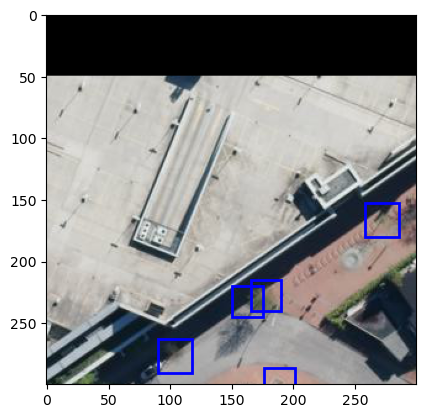

In [11]:
# Use the function
index = 0

bounding_boxes = find_bounding_boxes(targets[index].transpose())

# Now you can visualize the bounding boxes
fig, ax = plt.subplots()

ax.imshow(data[index])

for box in bounding_boxes:
    show_box(box, ax)

plt.show()

In [71]:
np.max(targets[15])

1.0

In [101]:
index = 2

image = data[index]
predictor.set_image(image)
bboxes = find_bounding_boxes(targets[index].transpose())
input_boxes = torch.tensor(bboxes, device=device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, scores, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
    return_logits=True
)

In [102]:

combined_mask = np.max(np.stack(masks.cpu()), axis=0)
combined_mask = np.reshape(combined_mask, (300,300))

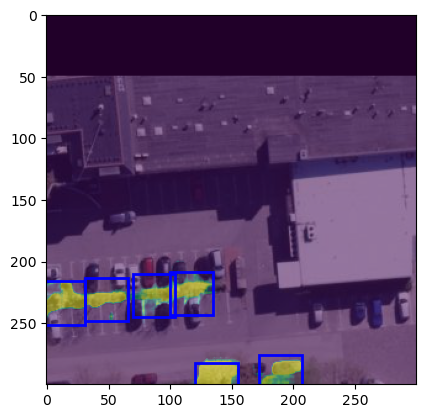

In [103]:
plt.imshow(image)
#for mask in masks:
#    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

mask_tensor = torch.from_numpy(combined_mask)
softmax_mask = torch.sigmoid(mask_tensor)
plt.imshow(softmax_mask, alpha=0.5)
#plt.imshow(np.reshape(combined_mask.cpu().numpy(), (300,300)), alpha=0.5)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())

In [104]:
threshold = 0
SAM_density_train = []
SAM_density_val = []
progress_bar = tqdm(range(len(data)))
zeroes_arr = torch.tensor(np.zeros((300, 300)))


print('Making sigmoid masks for training data')

for i in progress_bar:
    predictor.set_image(data[i])

    if np.max(targets[i])==1:

        bboxes = find_bounding_boxes(targets[i].transpose())
        input_boxes = torch.tensor(bboxes, device=device)

        transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
            return_logits=True
            )
        
        combined_mask = np.max(np.stack(masks.cpu()), axis=0)
        combined_mask = np.reshape(combined_mask, (300,300))

        mask_tensor = torch.from_numpy(combined_mask)
        sigmoid_mask = torch.sigmoid(mask_tensor)
        mask = np.array(density[i]).transpose() == 0
        n_t = torch.tensor(np.array(non_targets[i]).transpose())
        sigmoid_mask -= n_t
        sigmoid_mask[sigmoid_mask < threshold] = 0
        sigmoid_mask[mask] = 0
        sigmoid_mask = np.transpose(sigmoid_mask)

        SAM_density_train.append(sigmoid_mask)

        progress_bar.set_description(f'mask {i+1} has score {scores[2]}')


    else:
        try:
            input_label, input_points = get_points_a_labels(targets[i], non_targets[i], num_to_remove=0.99995, num_pos_remove=0.999)
        except:
            SAM_density_train.append(zeroes_arr)
            progress_bar.set_description(f'mask {i} had no points and was skipped')
            continue

        masks, scores, _ = predictor.predict(
                point_coords=input_points,
                point_labels=input_label,
                multimask_output=True,
                return_logits=True
            )
        
        mask_tensor = torch.from_numpy(masks[2])
        sigmoid_mask = torch.sigmoid(mask_tensor)
        mask = np.array(density[i]).transpose() == 0
        n_t = torch.tensor(np.array(non_targets[i]).transpose())
        sigmoid_mask -= n_t
        sigmoid_mask[sigmoid_mask < threshold] = 0
        sigmoid_mask[mask] = 0
        sigmoid_mask = np.transpose(sigmoid_mask)

        SAM_density_train.append(sigmoid_mask)

        progress_bar.set_description(f'mask {i+1} has score {scores[2]}')

progress_bar = tqdm(range(len(data_eval)))

print('Making sigmoid masks for validation data')

for i in progress_bar:
    predictor.set_image(data_eval[i])

    if np.max(targets_eval[i])==1:

        bboxes = find_bounding_boxes(targets_eval[i].transpose())
        input_boxes = torch.tensor(bboxes, device=device)

        transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
            return_logits=True
            )
        
        combined_mask = np.max(np.stack(masks.cpu()), axis=0)
        combined_mask = np.reshape(combined_mask, (300,300))

        mask_tensor = torch.from_numpy(combined_mask)
        sigmoid_mask = torch.sigmoid(mask_tensor)
        mask = np.array(density_eval[i]).transpose() == 0
        n_t = torch.tensor(np.array(non_targets_eval[i]).transpose())
        sigmoid_mask -= n_t
        sigmoid_mask[sigmoid_mask < threshold] = 0
        sigmoid_mask[mask] = 0
        sigmoid_mask = np.transpose(sigmoid_mask)

        SAM_density_val.append(sigmoid_mask)

        progress_bar.set_description(f'mask {i+1} has score {scores[2]}')


    else:
        try:
            input_label, input_points = get_points_a_labels(targets_eval[i], non_targets_eval[i], num_to_remove=0.99995, num_pos_remove=0.999)
        except:
            SAM_density_val.append(zeroes_arr)
            progress_bar.set_description(f'mask {i} had no points and was skipped')
            continue

        masks, scores, _ = predictor.predict(
                point_coords=input_points,
                point_labels=input_label,
                multimask_output=True,
                return_logits=True
            )
        
        mask_tensor = torch.from_numpy(masks[2])
        sigmoid_mask = torch.sigmoid(mask_tensor)
        mask = np.array(density_eval[i]).transpose() == 0
        n_t = torch.tensor(np.array(non_targets_eval[i]).transpose())
        sigmoid_mask -= n_t
        sigmoid_mask[sigmoid_mask < threshold] = 0
        sigmoid_mask[mask] = 0
        sigmoid_mask = np.transpose(sigmoid_mask)

        SAM_density_val.append(sigmoid_mask)

        progress_bar.set_description(f'mask {i+1} has score {scores[2]}')

""" 
    try:
        input_label, input_points = get_points_a_labels(targets_eval[i], non_targets_eval[i], num_to_remove=0.99995, num_pos_remove=0.999)
    except:
        SAM_density_val.append(zeroes_arr)
        progress_bar.set_description(f'mask {i} had no points and was skipped')
        continue

    masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_label,
            multimask_output=True,
            return_logits=True
        )
    
    mask_tensor = torch.from_numpy(masks[2])
    softmax_mask = torch.nn.functional.softmax(mask_tensor, dim=-1)
    mask = np.array(density_eval[i]).transpose() == 0
    n_t = torch.tensor(np.array(non_targets_eval[i]).transpose())
    softmax_mask -= n_t
    softmax_mask[softmax_mask < threshold] = 0
    softmax_mask[mask] = 0
    softmax_mask = np.transpose(softmax_mask)

    SAM_density_val.append(softmax_mask)

    progress_bar.set_description(f'mask {i+1} has score {scores[2]}')
"""

  0%|          | 0/3566 [00:00<?, ?it/s]

Making sigmoid masks for training data


mask 245 had no points and was skipped:   7%|▋         | 246/3566 [05:58<57:03,  1.03s/it]            

no points provided


mask 592 had no points and was skipped:  17%|█▋        | 593/3566 [15:25<46:12,  1.07it/s] 

no points provided


mask 622 had no points and was skipped:  17%|█▋        | 623/3566 [16:04<1:17:45,  1.59s/it]

no points provided


mask 936 had no points and was skipped:  26%|██▋       | 937/3566 [39:50<46:37,  1.06s/it]   

no points provided


mask 1082 had no points and was skipped:  30%|███       | 1083/3566 [42:50<45:09,  1.09s/it] 

no points provided


mask 1843 had no points and was skipped:  52%|█████▏    | 1844/3566 [1:17:34<1:22:55,  2.89s/it]

no points provided


mask 2464 has score 0.628642201423645:  69%|██████▉   | 2464/3566 [1:41:11<45:15,  2.46s/it]    


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import os
import torch
from tqdm import tqdm

save_dir = 'patches_SAM_boxes1'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_SAM_patches(directory, save_dir):
    for i in tqdm(range(3566)):  # Loop through indices for train samples
        filename = f"train_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                new_patch = torch.load(file_path)
                if torch.max(SAM_density_train[i])==0:
                    pass
                else:
                    new_patch['density'] = SAM_density_train[i]
                save_file_path = os.path.join(save_dir, filename)
                torch.save(new_patch, save_file_path)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    for i in tqdm(range(788)):  # Loop through indices for val samples
        filename = f"val_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                new_patch = torch.load(file_path)
                if torch.max(SAM_density_val[i])==0:
                    pass
                else:
                    new_patch['density'] = SAM_density_val[i]
                save_file_path = os.path.join(save_dir, filename)
                torch.save(new_patch, save_file_path)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

save_SAM_patches('patches', save_dir)


  0%|          | 7/3566 [00:00<00:51, 68.63it/s]

Error processing train_0.pt: expected np.ndarray (got Tensor)
Error processing train_1.pt: expected np.ndarray (got Tensor)
Error processing train_2.pt: expected np.ndarray (got Tensor)
Error processing train_3.pt: expected np.ndarray (got Tensor)
Error processing train_4.pt: expected np.ndarray (got Tensor)
Error processing train_5.pt: expected np.ndarray (got Tensor)
Error processing train_6.pt: expected np.ndarray (got Tensor)
Error processing train_7.pt: expected np.ndarray (got Tensor)
Error processing train_8.pt: expected np.ndarray (got Tensor)
Error processing train_9.pt: expected np.ndarray (got Tensor)
Error processing train_10.pt: expected np.ndarray (got Tensor)
Error processing train_11.pt: expected np.ndarray (got Tensor)
Error processing train_12.pt: expected np.ndarray (got Tensor)
Error processing train_13.pt: expected np.ndarray (got Tensor)


  1%|          | 23/3566 [00:00<00:52, 67.67it/s]

Error processing train_14.pt: expected np.ndarray (got Tensor)
Error processing train_15.pt: expected np.ndarray (got Tensor)
Error processing train_16.pt: expected np.ndarray (got Tensor)
Error processing train_17.pt: expected np.ndarray (got Tensor)
Error processing train_18.pt: expected np.ndarray (got Tensor)
Error processing train_19.pt: expected np.ndarray (got Tensor)
Error processing train_20.pt: expected np.ndarray (got Tensor)
Error processing train_21.pt: expected np.ndarray (got Tensor)
Error processing train_22.pt: expected np.ndarray (got Tensor)
Error processing train_23.pt: expected np.ndarray (got Tensor)
Error processing train_24.pt: expected np.ndarray (got Tensor)
Error processing train_25.pt: expected np.ndarray (got Tensor)
Error processing train_26.pt: expected np.ndarray (got Tensor)
Error processing train_27.pt: expected np.ndarray (got Tensor)
Error processing train_28.pt: expected np.ndarray (got Tensor)


  1%|          | 39/3566 [00:00<00:50, 69.55it/s]

Error processing train_29.pt: expected np.ndarray (got Tensor)
Error processing train_30.pt: expected np.ndarray (got Tensor)
Error processing train_31.pt: expected np.ndarray (got Tensor)
Error processing train_32.pt: expected np.ndarray (got Tensor)
Error processing train_33.pt: expected np.ndarray (got Tensor)
Error processing train_34.pt: expected np.ndarray (got Tensor)
Error processing train_35.pt: expected np.ndarray (got Tensor)
Error processing train_36.pt: expected np.ndarray (got Tensor)
Error processing train_37.pt: expected np.ndarray (got Tensor)
Error processing train_38.pt: expected np.ndarray (got Tensor)
Error processing train_39.pt: expected np.ndarray (got Tensor)
Error processing train_40.pt: expected np.ndarray (got Tensor)
Error processing train_41.pt: expected np.ndarray (got Tensor)
Error processing train_42.pt: expected np.ndarray (got Tensor)
Error processing train_43.pt: expected np.ndarray (got Tensor)


  2%|▏         | 56/3566 [00:00<00:45, 76.64it/s]

Error processing train_44.pt: expected np.ndarray (got Tensor)
Error processing train_45.pt: expected np.ndarray (got Tensor)
Error processing train_46.pt: expected np.ndarray (got Tensor)
Error processing train_47.pt: expected np.ndarray (got Tensor)
Error processing train_48.pt: expected np.ndarray (got Tensor)
Error processing train_49.pt: expected np.ndarray (got Tensor)
Error processing train_50.pt: expected np.ndarray (got Tensor)
Error processing train_51.pt: expected np.ndarray (got Tensor)
Error processing train_52.pt: expected np.ndarray (got Tensor)
Error processing train_53.pt: expected np.ndarray (got Tensor)
Error processing train_54.pt: expected np.ndarray (got Tensor)
Error processing train_55.pt: expected np.ndarray (got Tensor)
Error processing train_56.pt: expected np.ndarray (got Tensor)
Error processing train_57.pt: expected np.ndarray (got Tensor)
Error processing train_58.pt: expected np.ndarray (got Tensor)
Error processing train_59.pt: expected np.ndarray (got 

  2%|▏         | 74/3566 [00:00<00:44, 78.94it/s]

Error processing train_61.pt: expected np.ndarray (got Tensor)
Error processing train_62.pt: expected np.ndarray (got Tensor)
Error processing train_63.pt: expected np.ndarray (got Tensor)
Error processing train_64.pt: expected np.ndarray (got Tensor)
Error processing train_65.pt: expected np.ndarray (got Tensor)
Error processing train_66.pt: expected np.ndarray (got Tensor)
Error processing train_67.pt: expected np.ndarray (got Tensor)
Error processing train_68.pt: expected np.ndarray (got Tensor)
Error processing train_69.pt: expected np.ndarray (got Tensor)
Error processing train_70.pt: expected np.ndarray (got Tensor)
Error processing train_71.pt: expected np.ndarray (got Tensor)
Error processing train_72.pt: expected np.ndarray (got Tensor)
Error processing train_73.pt: expected np.ndarray (got Tensor)
Error processing train_74.pt: expected np.ndarray (got Tensor)
Error processing train_75.pt: expected np.ndarray (got Tensor)
Error processing train_76.pt: expected np.ndarray (got 

  3%|▎         | 90/3566 [00:01<00:47, 73.55it/s]

Error processing train_78.pt: expected np.ndarray (got Tensor)
Error processing train_79.pt: expected np.ndarray (got Tensor)
Error processing train_80.pt: expected np.ndarray (got Tensor)
Error processing train_81.pt: expected np.ndarray (got Tensor)
Error processing train_82.pt: expected np.ndarray (got Tensor)
Error processing train_83.pt: expected np.ndarray (got Tensor)
Error processing train_84.pt: expected np.ndarray (got Tensor)
Error processing train_85.pt: expected np.ndarray (got Tensor)
Error processing train_86.pt: expected np.ndarray (got Tensor)
Error processing train_87.pt: expected np.ndarray (got Tensor)
Error processing train_88.pt: expected np.ndarray (got Tensor)
Error processing train_89.pt: expected np.ndarray (got Tensor)
Error processing train_90.pt: expected np.ndarray (got Tensor)
Error processing train_91.pt: expected np.ndarray (got Tensor)
Error processing train_92.pt: expected np.ndarray (got Tensor)
Error processing train_93.pt: expected np.ndarray (got 

  3%|▎         | 108/3566 [00:01<00:43, 80.09it/s]

Error processing train_94.pt: expected np.ndarray (got Tensor)
Error processing train_95.pt: expected np.ndarray (got Tensor)
Error processing train_96.pt: expected np.ndarray (got Tensor)
Error processing train_97.pt: expected np.ndarray (got Tensor)
Error processing train_98.pt: expected np.ndarray (got Tensor)
Error processing train_99.pt: expected np.ndarray (got Tensor)
Error processing train_100.pt: expected np.ndarray (got Tensor)
Error processing train_101.pt: expected np.ndarray (got Tensor)
Error processing train_102.pt: expected np.ndarray (got Tensor)
Error processing train_103.pt: expected np.ndarray (got Tensor)
Error processing train_104.pt: expected np.ndarray (got Tensor)
Error processing train_105.pt: expected np.ndarray (got Tensor)
Error processing train_106.pt: expected np.ndarray (got Tensor)
Error processing train_107.pt: expected np.ndarray (got Tensor)
Error processing train_108.pt: expected np.ndarray (got Tensor)
Error processing train_109.pt: expected np.nda

  4%|▎         | 126/3566 [00:01<00:42, 80.21it/s]

Error processing train_112.pt: expected np.ndarray (got Tensor)
Error processing train_113.pt: expected np.ndarray (got Tensor)
Error processing train_114.pt: expected np.ndarray (got Tensor)
Error processing train_115.pt: expected np.ndarray (got Tensor)
Error processing train_116.pt: expected np.ndarray (got Tensor)
Error processing train_117.pt: expected np.ndarray (got Tensor)
Error processing train_118.pt: expected np.ndarray (got Tensor)
Error processing train_119.pt: expected np.ndarray (got Tensor)
Error processing train_120.pt: expected np.ndarray (got Tensor)
Error processing train_121.pt: expected np.ndarray (got Tensor)
Error processing train_122.pt: expected np.ndarray (got Tensor)
Error processing train_123.pt: expected np.ndarray (got Tensor)
Error processing train_124.pt: expected np.ndarray (got Tensor)
Error processing train_125.pt: expected np.ndarray (got Tensor)
Error processing train_126.pt: expected np.ndarray (got Tensor)
Error processing train_127.pt: expected 

  4%|▍         | 144/3566 [00:01<00:41, 82.69it/s]

Error processing train_128.pt: expected np.ndarray (got Tensor)
Error processing train_129.pt: expected np.ndarray (got Tensor)
Error processing train_130.pt: expected np.ndarray (got Tensor)
Error processing train_131.pt: expected np.ndarray (got Tensor)
Error processing train_132.pt: expected np.ndarray (got Tensor)
Error processing train_133.pt: expected np.ndarray (got Tensor)
Error processing train_134.pt: expected np.ndarray (got Tensor)
Error processing train_135.pt: expected np.ndarray (got Tensor)
Error processing train_136.pt: expected np.ndarray (got Tensor)
Error processing train_137.pt: expected np.ndarray (got Tensor)
Error processing train_138.pt: expected np.ndarray (got Tensor)
Error processing train_139.pt: expected np.ndarray (got Tensor)
Error processing train_140.pt: expected np.ndarray (got Tensor)
Error processing train_141.pt: expected np.ndarray (got Tensor)
Error processing train_142.pt: expected np.ndarray (got Tensor)
Error processing train_143.pt: expected 

  4%|▍         | 153/3566 [00:01<00:41, 83.12it/s]

Error processing train_144.pt: expected np.ndarray (got Tensor)
Error processing train_145.pt: expected np.ndarray (got Tensor)
Error processing train_146.pt: expected np.ndarray (got Tensor)
Error processing train_147.pt: expected np.ndarray (got Tensor)
Error processing train_148.pt: expected np.ndarray (got Tensor)
Error processing train_149.pt: expected np.ndarray (got Tensor)
Error processing train_150.pt: expected np.ndarray (got Tensor)
Error processing train_151.pt: expected np.ndarray (got Tensor)
Error processing train_152.pt: expected np.ndarray (got Tensor)
Error processing train_153.pt: expected np.ndarray (got Tensor)
Error processing train_154.pt: expected np.ndarray (got Tensor)
Error processing train_155.pt: expected np.ndarray (got Tensor)
Error processing train_156.pt: expected np.ndarray (got Tensor)
Error processing train_157.pt: expected np.ndarray (got Tensor)
Error processing train_158.pt: expected np.ndarray (got Tensor)
Error processing train_159.pt: expected 

  5%|▍         | 171/3566 [00:02<00:43, 77.31it/s]

Error processing train_161.pt: expected np.ndarray (got Tensor)
Error processing train_162.pt: expected np.ndarray (got Tensor)
Error processing train_163.pt: expected np.ndarray (got Tensor)
Error processing train_164.pt: expected np.ndarray (got Tensor)
Error processing train_165.pt: expected np.ndarray (got Tensor)
Error processing train_166.pt: expected np.ndarray (got Tensor)
Error processing train_167.pt: expected np.ndarray (got Tensor)
Error processing train_168.pt: expected np.ndarray (got Tensor)
Error processing train_169.pt: expected np.ndarray (got Tensor)
Error processing train_170.pt: expected np.ndarray (got Tensor)
Error processing train_171.pt: expected np.ndarray (got Tensor)
Error processing train_172.pt: expected np.ndarray (got Tensor)
Error processing train_173.pt: expected np.ndarray (got Tensor)
Error processing train_174.pt: expected np.ndarray (got Tensor)
Error processing train_175.pt: expected np.ndarray (got Tensor)


  5%|▌         | 187/3566 [00:02<00:46, 72.49it/s]

Error processing train_176.pt: expected np.ndarray (got Tensor)
Error processing train_177.pt: expected np.ndarray (got Tensor)
Error processing train_178.pt: expected np.ndarray (got Tensor)
Error processing train_179.pt: expected np.ndarray (got Tensor)
Error processing train_180.pt: expected np.ndarray (got Tensor)
Error processing train_181.pt: expected np.ndarray (got Tensor)
Error processing train_182.pt: expected np.ndarray (got Tensor)
Error processing train_183.pt: expected np.ndarray (got Tensor)
Error processing train_184.pt: expected np.ndarray (got Tensor)
Error processing train_185.pt: expected np.ndarray (got Tensor)
Error processing train_186.pt: expected np.ndarray (got Tensor)
Error processing train_187.pt: expected np.ndarray (got Tensor)
Error processing train_188.pt: expected np.ndarray (got Tensor)
Error processing train_189.pt: expected np.ndarray (got Tensor)


  6%|▌         | 203/3566 [00:02<00:45, 74.62it/s]

Error processing train_190.pt: expected np.ndarray (got Tensor)
Error processing train_191.pt: expected np.ndarray (got Tensor)
Error processing train_192.pt: expected np.ndarray (got Tensor)
Error processing train_193.pt: expected np.ndarray (got Tensor)
Error processing train_194.pt: expected np.ndarray (got Tensor)
Error processing train_195.pt: expected np.ndarray (got Tensor)
Error processing train_196.pt: expected np.ndarray (got Tensor)
Error processing train_197.pt: expected np.ndarray (got Tensor)
Error processing train_198.pt: expected np.ndarray (got Tensor)
Error processing train_199.pt: expected np.ndarray (got Tensor)
Error processing train_200.pt: expected np.ndarray (got Tensor)
Error processing train_201.pt: expected np.ndarray (got Tensor)
Error processing train_202.pt: expected np.ndarray (got Tensor)
Error processing train_203.pt: expected np.ndarray (got Tensor)
Error processing train_204.pt: expected np.ndarray (got Tensor)
Error processing train_205.pt: expected 

  6%|▌         | 219/3566 [00:02<00:43, 76.28it/s]

Error processing train_207.pt: expected np.ndarray (got Tensor)
Error processing train_208.pt: expected np.ndarray (got Tensor)
Error processing train_209.pt: expected np.ndarray (got Tensor)
Error processing train_210.pt: expected np.ndarray (got Tensor)
Error processing train_211.pt: expected np.ndarray (got Tensor)
Error processing train_212.pt: expected np.ndarray (got Tensor)
Error processing train_213.pt: expected np.ndarray (got Tensor)
Error processing train_214.pt: expected np.ndarray (got Tensor)
Error processing train_215.pt: expected np.ndarray (got Tensor)
Error processing train_216.pt: expected np.ndarray (got Tensor)
Error processing train_217.pt: expected np.ndarray (got Tensor)
Error processing train_218.pt: expected np.ndarray (got Tensor)
Error processing train_219.pt: expected np.ndarray (got Tensor)
Error processing train_220.pt: expected np.ndarray (got Tensor)
Error processing train_221.pt: expected np.ndarray (got Tensor)
Error processing train_222.pt: expected 

  7%|▋         | 234/3566 [00:03<00:43, 76.40it/s]


Error processing train_223.pt: expected np.ndarray (got Tensor)
Error processing train_224.pt: expected np.ndarray (got Tensor)
Error processing train_225.pt: expected np.ndarray (got Tensor)
Error processing train_226.pt: expected np.ndarray (got Tensor)
Error processing train_227.pt: expected np.ndarray (got Tensor)
Error processing train_228.pt: expected np.ndarray (got Tensor)
Error processing train_229.pt: expected np.ndarray (got Tensor)
Error processing train_230.pt: expected np.ndarray (got Tensor)
Error processing train_231.pt: expected np.ndarray (got Tensor)
Error processing train_232.pt: expected np.ndarray (got Tensor)
Error processing train_233.pt: expected np.ndarray (got Tensor)


KeyboardInterrupt: 

In [ ]:

data22, targets22, non_targets22, density22, data_eval22, targets_eval22, non_targets_eval22, density_eval22 = train_patches('patches_SAM')

print('Total train patches retrived:',len(data))
print('Total evaluation patches retrived:',len(data_eval))

Retrieving training data:


  0%|          | 8/3566 [00:00<00:48, 73.71it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  1%|          | 24/3566 [00:00<00:48, 72.48it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  1%|          | 40/3566 [00:00<00:51, 68.53it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  2%|▏         | 57/3566 [00:00<00:47, 74.12it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  2%|▏         | 74/3566 [00:00<00:44, 78.22it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  3%|▎         | 100/3566 [00:01<00:43, 80.21it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  3%|▎         | 109/3566 [00:01<00:42, 80.66it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  4%|▍         | 136/3566 [00:01<00:41, 81.90it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  4%|▍         | 145/3566 [00:01<00:41, 81.65it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  5%|▍         | 163/3566 [00:02<00:43, 77.57it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  5%|▌         | 179/3566 [00:02<00:45, 74.72it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  6%|▌         | 197/3566 [00:02<00:42, 79.31it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  6%|▌         | 215/3566 [00:02<00:42, 79.51it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  7%|▋         | 233/3566 [00:03<00:43, 75.92it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  7%|▋         | 241/3566 [00:03<00:43, 76.40it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


  7%|▋         | 260/3566 [00:03<00:42, 77.59it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 

In [ ]:
def process_patches(input_dir, output_dir):
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        # Check if the file is a .pt file and starts with "train_" or "val_"
        if filename.endswith(".pt") and (filename.startswith("train_") or filename.startswith("val_")):
            # Load the patch
            patch = torch.load(os.path.join(input_dir, filename))

            # Create a new patch
            new_patch = patch.copy()

            # Extract the number from the filename
            number = int(filename.split("_")[1].split(".")[0])

            # Update the density in the new patch
            if filename.startswith("train_"):
                new_patch['density'] = SAM_density_train[number]
            else:  # filename starts with "val_"
                new_patch['density'] = SAM_density_val[number]

            # Save the new patch
            torch.save(new_patch, os.path.join(output_dir, filename))

# Call the function to process the patches
process_patches("patches", "patches_SAM2")

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\caffe2\serialize\inline_container.cc:337] . unexpected pos 2342784 vs 2342688

In [ ]:
import re

save_dir = 'patches_SAM'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def extract_number_from_filename(file_path):
    number_match = re.search(r'train_(\d+)\.pt', file_path)
    if number_match:
        return int(number_match.group(1))
    else:
        return None

def save_SAM_patches(directory):
    for filename in tqdm(os.listdir(directory)):
        if filename.startswith("train_") and filename.endswith(".pt"):
            file_path = os.path.join(directory, filename)
            number = extract_number_from_filename(file_path)
            if number is not None:
                try:
                    patch = torch.load(file_path)
                    new_patch = patch.copy()
                    new_patch['density'] = SAM_density[number]

                    save_file_path = os.path.join(save_dir, filename)
                    torch.save(new_patch, save_file_path)

                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")

        if filename.startswith("val_") and filename.endswith(".pt"):
            file_path = os.path.join(directory, filename)
            number = extract_number_from_filename(file_path)
            if number is not None:
                try:
                    patch = torch.load(file_path)
                    new_patch = patch.copy()
                    new_patch['density'] = SAM_density[number]

                    save_file_path = os.path.join(save_dir, filename)
                    torch.save(new_patch, save_file_path)

                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")

save_SAM_patches(directory)

  0%|          | 0/4354 [00:00<?, ?it/s]

  1%|          | 38/4354 [00:00<00:30, 140.93it/s]

Error processing train_100.pt: list index out of range
Error processing train_1000.pt: list index out of range
Error processing train_1001.pt: list index out of range
Error processing train_1002.pt: list index out of range
Error processing train_1003.pt: list index out of range
Error processing train_1004.pt: list index out of range
Error processing train_1005.pt: list index out of range
Error processing train_1006.pt: list index out of range
Error processing train_1007.pt: list index out of range
Error processing train_1008.pt: list index out of range
Error processing train_1009.pt: list index out of range
Error processing train_101.pt: list index out of range
Error processing train_1010.pt: list index out of range
Error processing train_1011.pt: list index out of range
Error processing train_1012.pt: list index out of range
Error processing train_1013.pt: list index out of range
Error processing train_1014.pt: list index out of range
Error processing train_1015.pt: list index out of 

  1%|▏         | 56/4354 [00:00<00:28, 153.21it/s]

Error processing train_1031.pt: list index out of range
Error processing train_1032.pt: list index out of range
Error processing train_1033.pt: list index out of range
Error processing train_1034.pt: list index out of range
Error processing train_1035.pt: list index out of range
Error processing train_1036.pt: list index out of range
Error processing train_1037.pt: list index out of range
Error processing train_1038.pt: list index out of range
Error processing train_1039.pt: list index out of range
Error processing train_104.pt: list index out of range
Error processing train_1040.pt: list index out of range
Error processing train_1041.pt: list index out of range
Error processing train_1042.pt: list index out of range
Error processing train_1043.pt: list index out of range
Error processing train_1044.pt: list index out of range
Error processing train_1045.pt: list index out of range
Error processing train_1046.pt: list index out of range
Error processing train_1047.pt: list index out of

  2%|▏         | 91/4354 [00:00<00:26, 159.37it/s]

Error processing train_1063.pt: list index out of range
Error processing train_1064.pt: list index out of range
Error processing train_1065.pt: list index out of range
Error processing train_1066.pt: list index out of range
Error processing train_1067.pt: list index out of range
Error processing train_1068.pt: list index out of range
Error processing train_1069.pt: list index out of range
Error processing train_107.pt: list index out of range
Error processing train_1070.pt: list index out of range
Error processing train_1071.pt: list index out of range
Error processing train_1072.pt: list index out of range
Error processing train_1073.pt: list index out of range
Error processing train_1074.pt: list index out of range
Error processing train_1075.pt: list index out of range
Error processing train_1076.pt: list index out of range
Error processing train_1077.pt: list index out of range
Error processing train_1078.pt: list index out of range
Error processing train_1079.pt: list index out of

  3%|▎         | 127/4354 [00:00<00:27, 152.20it/s]

Error processing train_1096.pt: list index out of range
Error processing train_1097.pt: list index out of range
Error processing train_1098.pt: list index out of range
Error processing train_1099.pt: list index out of range
Error processing train_110.pt: list index out of range
Error processing train_1100.pt: list index out of range
Error processing train_1101.pt: list index out of range
Error processing train_1102.pt: list index out of range
Error processing train_1103.pt: list index out of range
Error processing train_1104.pt: list index out of range
Error processing train_1105.pt: list index out of range
Error processing train_1106.pt: list index out of range
Error processing train_1107.pt: list index out of range
Error processing train_1108.pt: list index out of range
Error processing train_1109.pt: list index out of range
Error processing train_111.pt: list index out of range
Error processing train_1110.pt: list index out of range
Error processing train_1111.pt: list index out of 

  4%|▎         | 162/4354 [00:01<00:26, 160.76it/s]

Error processing train_1122.pt: list index out of range
Error processing train_1123.pt: list index out of range
Error processing train_1124.pt: list index out of range
Error processing train_1125.pt: list index out of range
Error processing train_1126.pt: list index out of range
Error processing train_1127.pt: list index out of range
Error processing train_1128.pt: list index out of range
Error processing train_1129.pt: list index out of range
Error processing train_113.pt: list index out of range
Error processing train_1130.pt: list index out of range
Error processing train_1131.pt: list index out of range
Error processing train_1132.pt: list index out of range
Error processing train_1133.pt: list index out of range
Error processing train_1134.pt: list index out of range
Error processing train_1135.pt: list index out of range
Error processing train_1136.pt: list index out of range
Error processing train_1137.pt: list index out of range
Error processing train_1138.pt: list index out of

  5%|▍         | 199/4354 [00:01<00:24, 170.03it/s]

Error processing train_1152.pt: list index out of range
Error processing train_1153.pt: list index out of range
Error processing train_1154.pt: list index out of range
Error processing train_1155.pt: list index out of range
Error processing train_1156.pt: list index out of range
Error processing train_1157.pt: list index out of range
Error processing train_1158.pt: list index out of range
Error processing train_1159.pt: list index out of range
Error processing train_116.pt: list index out of range
Error processing train_1160.pt: list index out of range
Error processing train_1161.pt: list index out of range
Error processing train_1162.pt: list index out of range
Error processing train_1163.pt: list index out of range
Error processing train_1164.pt: list index out of range
Error processing train_1165.pt: list index out of range
Error processing train_1166.pt: list index out of range
Error processing train_1167.pt: list index out of range
Error processing train_1168.pt: list index out of

  5%|▌         | 235/4354 [00:01<00:24, 168.00it/s]

Error processing train_1189.pt: list index out of range
Error processing train_119.pt: list index out of range
Error processing train_1190.pt: list index out of range
Error processing train_1191.pt: list index out of range
Error processing train_1192.pt: list index out of range
Error processing train_1193.pt: list index out of range
Error processing train_1194.pt: list index out of range
Error processing train_1195.pt: list index out of range
Error processing train_1196.pt: list index out of range
Error processing train_1197.pt: list index out of range
Error processing train_1198.pt: list index out of range
Error processing train_1199.pt: list index out of range
Error processing train_120.pt: list index out of range
Error processing train_1200.pt: list index out of range
Error processing train_1201.pt: list index out of range
Error processing train_1202.pt: list index out of range
Error processing train_1203.pt: list index out of range
Error processing train_1204.pt: list index out of 

  6%|▌         | 272/4354 [00:01<00:23, 174.54it/s]

Error processing train_1220.pt: list index out of range
Error processing train_1221.pt: list index out of range
Error processing train_1222.pt: list index out of range
Error processing train_1223.pt: list index out of range
Error processing train_1224.pt: list index out of range
Error processing train_1225.pt: list index out of range
Error processing train_1226.pt: list index out of range
Error processing train_1227.pt: list index out of range
Error processing train_1228.pt: list index out of range
Error processing train_1229.pt: list index out of range
Error processing train_123.pt: list index out of range
Error processing train_1230.pt: list index out of range
Error processing train_1231.pt: list index out of range
Error processing train_1232.pt: list index out of range
Error processing train_1233.pt: list index out of range
Error processing train_1234.pt: list index out of range
Error processing train_1235.pt: list index out of range
Error processing train_1236.pt: list index out of

  7%|▋         | 311/4354 [00:01<00:22, 181.39it/s]

Error processing train_1258.pt: list index out of range
Error processing train_1259.pt: list index out of range
Error processing train_126.pt: list index out of range
Error processing train_1260.pt: list index out of range
Error processing train_1261.pt: list index out of range
Error processing train_1262.pt: list index out of range
Error processing train_1263.pt: list index out of range
Error processing train_1264.pt: list index out of range
Error processing train_1265.pt: list index out of range
Error processing train_1266.pt: list index out of range
Error processing train_1267.pt: list index out of range
Error processing train_1268.pt: list index out of range
Error processing train_1269.pt: list index out of range
Error processing train_127.pt: list index out of range
Error processing train_1270.pt: list index out of range
Error processing train_1271.pt: list index out of range
Error processing train_1272.pt: list index out of range
Error processing train_1273.pt: list index out of 

  8%|▊         | 349/4354 [00:02<00:22, 177.65it/s]

Error processing train_1291.pt: list index out of range
Error processing train_1292.pt: list index out of range
Error processing train_1293.pt: list index out of range
Error processing train_1294.pt: list index out of range
Error processing train_1295.pt: list index out of range
Error processing train_1296.pt: list index out of range
Error processing train_1297.pt: list index out of range
Error processing train_1298.pt: list index out of range
Error processing train_1299.pt: list index out of range
Error processing train_130.pt: list index out of range
Error processing train_1300.pt: list index out of range
Error processing train_1301.pt: list index out of range
Error processing train_1302.pt: list index out of range
Error processing train_1303.pt: list index out of range
Error processing train_1304.pt: list index out of range
Error processing train_1305.pt: list index out of range
Error processing train_1306.pt: list index out of range
Error processing train_1307.pt: list index out of

  9%|▉         | 388/4354 [00:02<00:21, 182.56it/s]

Error processing train_1327.pt: list index out of range
Error processing train_1328.pt: list index out of range
Error processing train_1329.pt: list index out of range
Error processing train_133.pt: list index out of range
Error processing train_1330.pt: list index out of range
Error processing train_1331.pt: list index out of range
Error processing train_1332.pt: list index out of range
Error processing train_1333.pt: list index out of range
Error processing train_1334.pt: list index out of range
Error processing train_1335.pt: list index out of range
Error processing train_1336.pt: list index out of range
Error processing train_1337.pt: list index out of range
Error processing train_1338.pt: list index out of range
Error processing train_1339.pt: list index out of range
Error processing train_134.pt: list index out of range
Error processing train_1340.pt: list index out of range
Error processing train_1341.pt: list index out of range
Error processing train_1342.pt: list index out of 

 10%|▉         | 427/4354 [00:02<00:21, 184.01it/s]

Error processing train_1361.pt: list index out of range
Error processing train_1362.pt: list index out of range
Error processing train_1363.pt: list index out of range
Error processing train_1364.pt: list index out of range
Error processing train_1365.pt: list index out of range
Error processing train_1366.pt: list index out of range
Error processing train_1367.pt: list index out of range
Error processing train_1368.pt: list index out of range
Error processing train_1369.pt: list index out of range
Error processing train_137.pt: list index out of range
Error processing train_1370.pt: list index out of range
Error processing train_1371.pt: list index out of range
Error processing train_1372.pt: list index out of range
Error processing train_1373.pt: list index out of range
Error processing train_1374.pt: list index out of range
Error processing train_1375.pt: list index out of range
Error processing train_1376.pt: list index out of range
Error processing train_1377.pt: list index out of

 11%|█         | 465/4354 [00:02<00:21, 177.08it/s]

Error processing train_1394.pt: list index out of range
Error processing train_1395.pt: list index out of range
Error processing train_1396.pt: list index out of range
Error processing train_1397.pt: list index out of range
Error processing train_1398.pt: list index out of range
Error processing train_1399.pt: list index out of range
Error processing train_140.pt: list index out of range
Error processing train_1400.pt: list index out of range
Error processing train_1401.pt: list index out of range
Error processing train_1402.pt: list index out of range
Error processing train_1403.pt: list index out of range
Error processing train_1404.pt: list index out of range
Error processing train_1405.pt: list index out of range
Error processing train_1406.pt: list index out of range
Error processing train_1407.pt: list index out of range
Error processing train_1408.pt: list index out of range
Error processing train_1409.pt: list index out of range
Error processing train_141.pt: list index out of 

 12%|█▏        | 503/4354 [00:02<00:21, 180.29it/s]

Error processing train_1428.pt: list index out of range
Error processing train_1429.pt: list index out of range
Error processing train_143.pt: list index out of range
Error processing train_1430.pt: list index out of range
Error processing train_1431.pt: list index out of range
Error processing train_1432.pt: list index out of range
Error processing train_1433.pt: list index out of range
Error processing train_1434.pt: list index out of range
Error processing train_1435.pt: list index out of range
Error processing train_1436.pt: list index out of range
Error processing train_1437.pt: list index out of range
Error processing train_1438.pt: list index out of range
Error processing train_1439.pt: list index out of range
Error processing train_144.pt: list index out of range
Error processing train_1440.pt: list index out of range
Error processing train_1441.pt: list index out of range
Error processing train_1442.pt: list index out of range
Error processing train_1443.pt: list index out of 

 12%|█▏        | 541/4354 [00:03<00:20, 181.92it/s]

Error processing train_1462.pt: list index out of range
Error processing train_1463.pt: list index out of range
Error processing train_1464.pt: list index out of range
Error processing train_1465.pt: list index out of range
Error processing train_1466.pt: list index out of range
Error processing train_1467.pt: list index out of range
Error processing train_1468.pt: list index out of range
Error processing train_1469.pt: list index out of range
Error processing train_147.pt: list index out of range
Error processing train_1470.pt: list index out of range
Error processing train_1471.pt: list index out of range
Error processing train_1472.pt: list index out of range
Error processing train_1473.pt: list index out of range
Error processing train_1474.pt: list index out of range
Error processing train_1475.pt: list index out of range
Error processing train_1476.pt: list index out of range
Error processing train_1477.pt: list index out of range
Error processing train_1478.pt: list index out of

 13%|█▎        | 579/4354 [00:03<00:20, 183.54it/s]

Error processing train_1497.pt: list index out of range
Error processing train_1498.pt: list index out of range
Error processing train_1499.pt: list index out of range
Error processing train_150.pt: list index out of range
Error processing train_1500.pt: list index out of range
Error processing train_1501.pt: list index out of range
Error processing train_1502.pt: list index out of range
Error processing train_1503.pt: list index out of range
Error processing train_1504.pt: list index out of range
Error processing train_1505.pt: list index out of range
Error processing train_1506.pt: list index out of range
Error processing train_1507.pt: list index out of range
Error processing train_1508.pt: list index out of range
Error processing train_1509.pt: list index out of range
Error processing train_151.pt: list index out of range
Error processing train_1510.pt: list index out of range
Error processing train_1511.pt: list index out of range
Error processing train_1512.pt: list index out of 

 14%|█▍        | 617/4354 [00:03<00:20, 185.62it/s]

Error processing train_153.pt: list index out of range
Error processing train_1530.pt: list index out of range
Error processing train_1531.pt: list index out of range
Error processing train_1532.pt: list index out of range
Error processing train_1533.pt: list index out of range
Error processing train_1534.pt: list index out of range
Error processing train_1535.pt: list index out of range
Error processing train_1536.pt: list index out of range
Error processing train_1537.pt: list index out of range
Error processing train_1538.pt: list index out of range
Error processing train_1539.pt: list index out of range
Error processing train_154.pt: list index out of range
Error processing train_1540.pt: list index out of range
Error processing train_1541.pt: list index out of range
Error processing train_1542.pt: list index out of range
Error processing train_1543.pt: list index out of range
Error processing train_1544.pt: list index out of range
Error processing train_1545.pt: list index out of 

 15%|█▌        | 655/4354 [00:03<00:20, 180.61it/s]

Error processing train_1561.pt: list index out of range
Error processing train_1562.pt: list index out of range
Error processing train_1563.pt: list index out of range
Error processing train_1564.pt: list index out of range
Error processing train_1565.pt: list index out of range
Error processing train_1566.pt: list index out of range
Error processing train_1567.pt: list index out of range
Error processing train_1568.pt: list index out of range
Error processing train_1569.pt: list index out of range
Error processing train_157.pt: list index out of range
Error processing train_1570.pt: list index out of range
Error processing train_1571.pt: list index out of range
Error processing train_1572.pt: list index out of range
Error processing train_1573.pt: list index out of range
Error processing train_1574.pt: list index out of range
Error processing train_1575.pt: list index out of range
Error processing train_1576.pt: list index out of range
Error processing train_1577.pt: list index out of

 16%|█▌        | 692/4354 [00:04<00:20, 176.03it/s]

Error processing train_1595.pt: list index out of range
Error processing train_1596.pt: list index out of range
Error processing train_1597.pt: list index out of range
Error processing train_1598.pt: list index out of range
Error processing train_1599.pt: list index out of range
Error processing train_160.pt: list index out of range
Error processing train_1600.pt: list index out of range
Error processing train_1601.pt: list index out of range
Error processing train_1602.pt: list index out of range
Error processing train_1603.pt: list index out of range
Error processing train_1604.pt: list index out of range
Error processing train_1605.pt: list index out of range
Error processing train_1606.pt: list index out of range
Error processing train_1607.pt: list index out of range
Error processing train_1608.pt: list index out of range
Error processing train_1609.pt: list index out of range
Error processing train_161.pt: list index out of range
Error processing train_1610.pt: list index out of 

 17%|█▋        | 729/4354 [00:04<00:20, 176.89it/s]

Error processing train_1626.pt: list index out of range
Error processing train_1627.pt: list index out of range
Error processing train_1628.pt: list index out of range
Error processing train_1629.pt: list index out of range
Error processing train_163.pt: list index out of range
Error processing train_1630.pt: list index out of range
Error processing train_1631.pt: list index out of range
Error processing train_1632.pt: list index out of range
Error processing train_1633.pt: list index out of range
Error processing train_1634.pt: list index out of range
Error processing train_1635.pt: list index out of range
Error processing train_1636.pt: list index out of range
Error processing train_1637.pt: list index out of range
Error processing train_1638.pt: list index out of range
Error processing train_1639.pt: list index out of range
Error processing train_164.pt: list index out of range
Error processing train_1640.pt: list index out of range
Error processing train_1641.pt: list index out of 

 18%|█▊        | 767/4354 [00:04<00:19, 180.83it/s]

Error processing train_1661.pt: list index out of range
Error processing train_1662.pt: list index out of range
Error processing train_1663.pt: list index out of range
Error processing train_1664.pt: list index out of range
Error processing train_1665.pt: list index out of range
Error processing train_1666.pt: list index out of range
Error processing train_1667.pt: list index out of range
Error processing train_1668.pt: list index out of range
Error processing train_1669.pt: list index out of range
Error processing train_167.pt: list index out of range
Error processing train_1670.pt: list index out of range
Error processing train_1671.pt: list index out of range
Error processing train_1672.pt: list index out of range
Error processing train_1673.pt: list index out of range
Error processing train_1674.pt: list index out of range
Error processing train_1675.pt: list index out of range
Error processing train_1676.pt: list index out of range
Error processing train_1677.pt: list index out of

 18%|█▊        | 804/4354 [00:04<00:20, 176.95it/s]

Error processing train_1697.pt: list index out of range
Error processing train_1698.pt: list index out of range
Error processing train_1699.pt: list index out of range
Error processing train_170.pt: list index out of range
Error processing train_1700.pt: list index out of range
Error processing train_1701.pt: list index out of range
Error processing train_1702.pt: list index out of range
Error processing train_1703.pt: list index out of range
Error processing train_1704.pt: list index out of range
Error processing train_1705.pt: list index out of range
Error processing train_1706.pt: list index out of range
Error processing train_1707.pt: list index out of range
Error processing train_1708.pt: list index out of range
Error processing train_1709.pt: list index out of range
Error processing train_171.pt: list index out of range
Error processing train_1710.pt: list index out of range
Error processing train_1711.pt: list index out of range
Error processing train_1712.pt: list index out of 

 19%|█▉        | 841/4354 [00:04<00:19, 178.91it/s]

Error processing train_1730.pt: list index out of range
Error processing train_1731.pt: list index out of range
Error processing train_1732.pt: list index out of range
Error processing train_1733.pt: list index out of range
Error processing train_1734.pt: list index out of range
Error processing train_1735.pt: list index out of range
Error processing train_1736.pt: list index out of range
Error processing train_1737.pt: list index out of range
Error processing train_1738.pt: list index out of range
Error processing train_1739.pt: list index out of range
Error processing train_174.pt: list index out of range
Error processing train_1740.pt: list index out of range
Error processing train_1741.pt: list index out of range
Error processing train_1742.pt: list index out of range
Error processing train_1743.pt: list index out of range
Error processing train_1744.pt: list index out of range
Error processing train_1745.pt: list index out of range
Error processing train_1746.pt: list index out of

 20%|██        | 879/4354 [00:05<00:19, 181.35it/s]

Error processing train_1767.pt: list index out of range
Error processing train_1768.pt: list index out of range
Error processing train_1769.pt: list index out of range
Error processing train_177.pt: list index out of range
Error processing train_1770.pt: list index out of range
Error processing train_1771.pt: list index out of range
Error processing train_1772.pt: list index out of range
Error processing train_1773.pt: list index out of range
Error processing train_1774.pt: list index out of range
Error processing train_1775.pt: list index out of range
Error processing train_1776.pt: list index out of range
Error processing train_1777.pt: list index out of range
Error processing train_1778.pt: list index out of range
Error processing train_1779.pt: list index out of range
Error processing train_178.pt: list index out of range
Error processing train_1780.pt: list index out of range
Error processing train_1781.pt: list index out of range
Error processing train_1782.pt: list index out of 

 21%|██        | 917/4354 [00:05<00:19, 178.20it/s]

Error processing train_1801.pt: list index out of range
Error processing train_1802.pt: list index out of range
Error processing train_1803.pt: list index out of range
Error processing train_1804.pt: list index out of range
Error processing train_1805.pt: list index out of range
Error processing train_1806.pt: list index out of range
Error processing train_1807.pt: list index out of range
Error processing train_1808.pt: list index out of range
Error processing train_1809.pt: list index out of range
Error processing train_181.pt: list index out of range
Error processing train_1810.pt: list index out of range
Error processing train_1811.pt: list index out of range
Error processing train_1812.pt: list index out of range
Error processing train_1813.pt: list index out of range
Error processing train_1814.pt: list index out of range
Error processing train_1815.pt: list index out of range
Error processing train_1816.pt: list index out of range
Error processing train_1817.pt: list index out of

 22%|██▏       | 955/4354 [00:05<00:18, 180.57it/s]

Error processing train_1838.pt: list index out of range
Error processing train_1839.pt: list index out of range
Error processing train_184.pt: list index out of range
Error processing train_1840.pt: list index out of range
Error processing train_1841.pt: list index out of range
Error processing train_1842.pt: list index out of range
Error processing train_1843.pt: list index out of range
Error processing train_1844.pt: list index out of range
Error processing train_1845.pt: list index out of range
Error processing train_1846.pt: list index out of range
Error processing train_1847.pt: list index out of range
Error processing train_1848.pt: list index out of range
Error processing train_1849.pt: list index out of range
Error processing train_185.pt: list index out of range
Error processing train_1850.pt: list index out of range
Error processing train_1851.pt: list index out of range
Error processing train_1852.pt: list index out of range
Error processing train_1853.pt: list index out of 

 23%|██▎       | 1012/4354 [00:05<00:18, 181.91it/s]

Error processing train_1873.pt: list index out of range
Error processing train_1874.pt: list index out of range
Error processing train_1875.pt: list index out of range
Error processing train_1876.pt: list index out of range
Error processing train_1877.pt: list index out of range
Error processing train_1878.pt: list index out of range
Error processing train_1879.pt: list index out of range
Error processing train_188.pt: list index out of range
Error processing train_1880.pt: list index out of range
Error processing train_1881.pt: list index out of range
Error processing train_1882.pt: list index out of range
Error processing train_1883.pt: list index out of range
Error processing train_1884.pt: list index out of range
Error processing train_1885.pt: list index out of range
Error processing train_1886.pt: list index out of range
Error processing train_1887.pt: list index out of range
Error processing train_1888.pt: list index out of range
Error processing train_1889.pt: list index out of

 24%|██▎       | 1031/4354 [00:05<00:18, 181.68it/s]

Error processing train_1909.pt: list index out of range
Error processing train_191.pt: list index out of range
Error processing train_1910.pt: list index out of range
Error processing train_1911.pt: list index out of range
Error processing train_1912.pt: list index out of range
Error processing train_1913.pt: list index out of range
Error processing train_1914.pt: list index out of range
Error processing train_1915.pt: list index out of range
Error processing train_1916.pt: list index out of range
Error processing train_1917.pt: list index out of range
Error processing train_1918.pt: list index out of range
Error processing train_1919.pt: list index out of range
Error processing train_192.pt: list index out of range
Error processing train_1920.pt: list index out of range
Error processing train_1921.pt: list index out of range
Error processing train_1922.pt: list index out of range
Error processing train_1923.pt: list index out of range
Error processing train_1924.pt: list index out of 

 25%|██▍       | 1069/4354 [00:06<00:18, 181.28it/s]

Error processing train_194.pt: list index out of range
Error processing train_1940.pt: list index out of range
Error processing train_1941.pt: list index out of range
Error processing train_1942.pt: list index out of range
Error processing train_1943.pt: list index out of range
Error processing train_1944.pt: list index out of range
Error processing train_1945.pt: list index out of range
Error processing train_1946.pt: list index out of range
Error processing train_1947.pt: list index out of range
Error processing train_1948.pt: list index out of range
Error processing train_1949.pt: list index out of range
Error processing train_195.pt: list index out of range
Error processing train_1950.pt: list index out of range
Error processing train_1951.pt: list index out of range
Error processing train_1952.pt: list index out of range
Error processing train_1953.pt: list index out of range
Error processing train_1954.pt: list index out of range
Error processing train_1955.pt: list index out of 

 25%|██▌       | 1107/4354 [00:06<00:17, 183.82it/s]

Error processing train_1974.pt: list index out of range
Error processing train_1975.pt: list index out of range
Error processing train_1976.pt: list index out of range
Error processing train_1977.pt: list index out of range
Error processing train_1978.pt: list index out of range
Error processing train_1979.pt: list index out of range
Error processing train_198.pt: list index out of range
Error processing train_1980.pt: list index out of range
Error processing train_1981.pt: list index out of range
Error processing train_1982.pt: list index out of range
Error processing train_1983.pt: list index out of range
Error processing train_1984.pt: list index out of range
Error processing train_1985.pt: list index out of range
Error processing train_1986.pt: list index out of range
Error processing train_1987.pt: list index out of range
Error processing train_1988.pt: list index out of range
Error processing train_1989.pt: list index out of range
Error processing train_199.pt: list index out of 

 26%|██▋       | 1145/4354 [00:06<00:18, 172.71it/s]

Error processing train_2001.pt: list index out of range
Error processing train_2002.pt: list index out of range
Error processing train_2003.pt: list index out of range
Error processing train_2004.pt: list index out of range
Error processing train_2005.pt: list index out of range
Error processing train_2006.pt: list index out of range
Error processing train_2007.pt: list index out of range
Error processing train_2008.pt: list index out of range
Error processing train_2009.pt: list index out of range
Error processing train_201.pt: list index out of range
Error processing train_2010.pt: list index out of range
Error processing train_2011.pt: list index out of range
Error processing train_2012.pt: list index out of range
Error processing train_2013.pt: list index out of range
Error processing train_2014.pt: list index out of range
Error processing train_2015.pt: list index out of range
Error processing train_2016.pt: list index out of range
Error processing train_2017.pt: list index out of

 27%|██▋       | 1182/4354 [00:06<00:17, 176.94it/s]

Error processing train_2037.pt: list index out of range
Error processing train_2038.pt: list index out of range
Error processing train_2039.pt: list index out of range
Error processing train_204.pt: list index out of range
Error processing train_2040.pt: list index out of range
Error processing train_2041.pt: list index out of range
Error processing train_2042.pt: list index out of range
Error processing train_2043.pt: list index out of range
Error processing train_2044.pt: list index out of range
Error processing train_2045.pt: list index out of range
Error processing train_2046.pt: list index out of range
Error processing train_2047.pt: list index out of range
Error processing train_2048.pt: list index out of range
Error processing train_2049.pt: list index out of range
Error processing train_205.pt: list index out of range
Error processing train_2050.pt: list index out of range
Error processing train_2051.pt: list index out of range
Error processing train_2052.pt: list index out of 

 28%|██▊       | 1220/4354 [00:06<00:17, 181.29it/s]

Error processing train_2073.pt: list index out of range
Error processing train_2074.pt: list index out of range
Error processing train_2075.pt: list index out of range
Error processing train_2076.pt: list index out of range
Error processing train_2077.pt: list index out of range
Error processing train_2078.pt: list index out of range
Error processing train_2079.pt: list index out of range
Error processing train_208.pt: list index out of range
Error processing train_2080.pt: list index out of range
Error processing train_2081.pt: list index out of range
Error processing train_2082.pt: list index out of range
Error processing train_2083.pt: list index out of range
Error processing train_2084.pt: list index out of range
Error processing train_2085.pt: list index out of range
Error processing train_2086.pt: list index out of range
Error processing train_2087.pt: list index out of range
Error processing train_2088.pt: list index out of range
Error processing train_2089.pt: list index out of

 29%|██▉       | 1258/4354 [00:07<00:17, 178.85it/s]

Error processing train_2109.pt: list index out of range
Error processing train_211.pt: list index out of range
Error processing train_2110.pt: list index out of range
Error processing train_2111.pt: list index out of range
Error processing train_2112.pt: list index out of range
Error processing train_2113.pt: list index out of range
Error processing train_2114.pt: list index out of range
Error processing train_2115.pt: list index out of range
Error processing train_2116.pt: list index out of range
Error processing train_2117.pt: list index out of range
Error processing train_2118.pt: list index out of range
Error processing train_2119.pt: list index out of range
Error processing train_212.pt: list index out of range
Error processing train_2120.pt: list index out of range
Error processing train_2121.pt: list index out of range
Error processing train_2122.pt: list index out of range
Error processing train_2123.pt: list index out of range
Error processing train_2124.pt: list index out of 

 30%|██▉       | 1296/4354 [00:07<00:16, 180.12it/s]

Error processing train_2144.pt: list index out of range
Error processing train_2145.pt: list index out of range
Error processing train_2146.pt: list index out of range
Error processing train_2147.pt: list index out of range
Error processing train_2148.pt: list index out of range
Error processing train_2149.pt: list index out of range
Error processing train_215.pt: list index out of range
Error processing train_2150.pt: list index out of range
Error processing train_2151.pt: list index out of range
Error processing train_2152.pt: list index out of range
Error processing train_2153.pt: list index out of range
Error processing train_2154.pt: list index out of range
Error processing train_2155.pt: list index out of range
Error processing train_2156.pt: list index out of range
Error processing train_2157.pt: list index out of range
Error processing train_2158.pt: list index out of range
Error processing train_2159.pt: list index out of range
Error processing train_216.pt: list index out of 

 31%|███       | 1353/4354 [00:07<00:16, 182.45it/s]

Error processing train_218.pt: list index out of range
Error processing train_2180.pt: list index out of range
Error processing train_2181.pt: list index out of range
Error processing train_2182.pt: list index out of range
Error processing train_2183.pt: list index out of range
Error processing train_2184.pt: list index out of range
Error processing train_2185.pt: list index out of range
Error processing train_2186.pt: list index out of range
Error processing train_2187.pt: list index out of range
Error processing train_2188.pt: list index out of range
Error processing train_2189.pt: list index out of range
Error processing train_219.pt: list index out of range
Error processing train_2190.pt: list index out of range
Error processing train_2191.pt: list index out of range
Error processing train_2192.pt: list index out of range
Error processing train_2193.pt: list index out of range
Error processing train_2194.pt: list index out of range
Error processing train_2195.pt: list index out of 

 32%|███▏      | 1391/4354 [00:07<00:16, 183.94it/s]

Error processing train_2215.pt: list index out of range
Error processing train_2216.pt: list index out of range
Error processing train_2217.pt: list index out of range
Error processing train_2218.pt: list index out of range
Error processing train_2219.pt: list index out of range
Error processing train_222.pt: list index out of range
Error processing train_2220.pt: list index out of range
Error processing train_2221.pt: list index out of range
Error processing train_2222.pt: list index out of range
Error processing train_2223.pt: list index out of range
Error processing train_2224.pt: list index out of range
Error processing train_2225.pt: list index out of range
Error processing train_2226.pt: list index out of range
Error processing train_2227.pt: list index out of range
Error processing train_2228.pt: list index out of range
Error processing train_2229.pt: list index out of range
Error processing train_223.pt: list index out of range
Error processing train_2230.pt: list index out of 

 32%|███▏      | 1410/4354 [00:08<00:16, 174.30it/s]

Error processing train_225.pt: list index out of range
Error processing train_2250.pt: list index out of range
Error processing train_2251.pt: list index out of range
Error processing train_2252.pt: list index out of range
Error processing train_2253.pt: list index out of range
Error processing train_2254.pt: list index out of range
Error processing train_2255.pt: list index out of range
Error processing train_2256.pt: list index out of range
Error processing train_2257.pt: list index out of range
Error processing train_2258.pt: list index out of range
Error processing train_2259.pt: list index out of range
Error processing train_226.pt: list index out of range
Error processing train_2260.pt: list index out of range
Error processing train_2261.pt: list index out of range
Error processing train_2262.pt: list index out of range
Error processing train_2263.pt: list index out of range
Error processing train_2264.pt: list index out of range
Error processing train_2265.pt: list index out of 

 33%|███▎      | 1447/4354 [00:08<00:16, 174.05it/s]

Error processing train_2280.pt: list index out of range
Error processing train_2281.pt: list index out of range
Error processing train_2282.pt: list index out of range
Error processing train_2283.pt: list index out of range
Error processing train_2284.pt: list index out of range
Error processing train_2285.pt: list index out of range
Error processing train_2286.pt: list index out of range
Error processing train_2287.pt: list index out of range
Error processing train_2288.pt: list index out of range
Error processing train_2289.pt: list index out of range
Error processing train_229.pt: list index out of range
Error processing train_2290.pt: list index out of range
Error processing train_2291.pt: list index out of range
Error processing train_2292.pt: list index out of range
Error processing train_2293.pt: list index out of range
Error processing train_2294.pt: list index out of range
Error processing train_2295.pt: list index out of range
Error processing train_2296.pt: list index out of

 35%|███▍      | 1504/4354 [00:08<00:15, 179.03it/s]

Error processing train_2315.pt: list index out of range
Error processing train_2316.pt: list index out of range
Error processing train_2317.pt: list index out of range
Error processing train_2318.pt: list index out of range
Error processing train_2319.pt: list index out of range
Error processing train_232.pt: list index out of range
Error processing train_2320.pt: list index out of range
Error processing train_2321.pt: list index out of range
Error processing train_2322.pt: list index out of range
Error processing train_2323.pt: list index out of range
Error processing train_2324.pt: list index out of range
Error processing train_2325.pt: list index out of range
Error processing train_2326.pt: list index out of range
Error processing train_2327.pt: list index out of range
Error processing train_2328.pt: list index out of range
Error processing train_2329.pt: list index out of range
Error processing train_233.pt: list index out of range
Error processing train_2330.pt: list index out of 

 35%|███▍      | 1522/4354 [00:08<00:17, 160.65it/s]

Error processing train_2351.pt: list index out of range
Error processing train_2352.pt: list index out of range
Error processing train_2353.pt: list index out of range
Error processing train_2354.pt: list index out of range
Error processing train_2355.pt: list index out of range
Error processing train_2356.pt: list index out of range
Error processing train_2357.pt: list index out of range
Error processing train_2358.pt: list index out of range
Error processing train_2359.pt: list index out of range
Error processing train_236.pt: list index out of range
Error processing train_2360.pt: list index out of range
Error processing train_2361.pt: list index out of range
Error processing train_2362.pt: list index out of range
Error processing train_2363.pt: list index out of range
Error processing train_2364.pt: list index out of range
Error processing train_2365.pt: list index out of range
Error processing train_2366.pt: list index out of range
Error processing train_2367.pt: list index out of

 36%|███▌      | 1558/4354 [00:08<00:16, 167.63it/s]

Error processing train_2376.pt: list index out of range
Error processing train_2377.pt: list index out of range
Error processing train_2378.pt: list index out of range
Error processing train_2379.pt: list index out of range
Error processing train_238.pt: list index out of range
Error processing train_2380.pt: list index out of range
Error processing train_2381.pt: list index out of range
Error processing train_2382.pt: list index out of range
Error processing train_2383.pt: list index out of range
Error processing train_2384.pt: list index out of range
Error processing train_2385.pt: list index out of range
Error processing train_2386.pt: list index out of range
Error processing train_2387.pt: list index out of range
Error processing train_2388.pt: list index out of range
Error processing train_2389.pt: list index out of range
Error processing train_239.pt: list index out of range
Error processing train_2390.pt: list index out of range
Error processing train_2391.pt: list index out of 

 37%|███▋      | 1596/4354 [00:09<00:15, 176.41it/s]

Error processing train_241.pt: list index out of range
Error processing train_2410.pt: list index out of range
Error processing train_2411.pt: list index out of range
Error processing train_2412.pt: list index out of range
Error processing train_2413.pt: list index out of range
Error processing train_2414.pt: list index out of range
Error processing train_2415.pt: list index out of range
Error processing train_2416.pt: list index out of range
Error processing train_2417.pt: list index out of range
Error processing train_2418.pt: list index out of range
Error processing train_2419.pt: list index out of range
Error processing train_242.pt: list index out of range
Error processing train_2420.pt: list index out of range
Error processing train_2421.pt: list index out of range
Error processing train_2422.pt: list index out of range
Error processing train_2423.pt: list index out of range
Error processing train_2424.pt: list index out of range
Error processing train_2425.pt: list index out of 

 38%|███▊      | 1633/4354 [00:09<00:15, 178.46it/s]

Error processing train_2445.pt: list index out of range
Error processing train_2446.pt: list index out of range
Error processing train_2447.pt: list index out of range
Error processing train_2448.pt: list index out of range
Error processing train_2449.pt: list index out of range
Error processing train_245.pt: list index out of range
Error processing train_2450.pt: list index out of range
Error processing train_2451.pt: list index out of range
Error processing train_2452.pt: list index out of range
Error processing train_2453.pt: list index out of range
Error processing train_2454.pt: list index out of range
Error processing train_2455.pt: list index out of range
Error processing train_2456.pt: list index out of range
Error processing train_2457.pt: list index out of range
Error processing train_2458.pt: list index out of range
Error processing train_2459.pt: list index out of range
Error processing train_246.pt: list index out of range
Error processing train_2460.pt: list index out of 

 38%|███▊      | 1671/4354 [00:09<00:14, 179.91it/s]

Error processing train_2479.pt: list index out of range
Error processing train_248.pt: list index out of range
Error processing train_2480.pt: list index out of range
Error processing train_2481.pt: list index out of range
Error processing train_2482.pt: list index out of range
Error processing train_2483.pt: list index out of range
Error processing train_2484.pt: list index out of range
Error processing train_2485.pt: list index out of range
Error processing train_2486.pt: list index out of range
Error processing train_2487.pt: list index out of range
Error processing train_2488.pt: list index out of range
Error processing train_2489.pt: list index out of range
Error processing train_249.pt: list index out of range
Error processing train_2490.pt: list index out of range
Error processing train_2491.pt: list index out of range
Error processing train_2492.pt: list index out of range
Error processing train_2493.pt: list index out of range
Error processing train_2494.pt: list index out of 

 39%|███▉      | 1709/4354 [00:09<00:14, 176.33it/s]

Error processing train_2513.pt: list index out of range
Error processing train_2514.pt: list index out of range
Error processing train_2515.pt: list index out of range
Error processing train_2516.pt: list index out of range
Error processing train_2517.pt: list index out of range
Error processing train_2518.pt: list index out of range
Error processing train_2519.pt: list index out of range
Error processing train_252.pt: list index out of range
Error processing train_2520.pt: list index out of range
Error processing train_2521.pt: list index out of range
Error processing train_2522.pt: list index out of range
Error processing train_2523.pt: list index out of range
Error processing train_2524.pt: list index out of range
Error processing train_2525.pt: list index out of range
Error processing train_2526.pt: list index out of range
Error processing train_2527.pt: list index out of range
Error processing train_2528.pt: list index out of range
Error processing train_2529.pt: list index out of

 40%|████      | 1746/4354 [00:09<00:14, 179.27it/s]

Error processing train_2547.pt: list index out of range
Error processing train_2548.pt: list index out of range
Error processing train_2549.pt: list index out of range
Error processing train_255.pt: list index out of range
Error processing train_2550.pt: list index out of range
Error processing train_2551.pt: list index out of range
Error processing train_2552.pt: list index out of range
Error processing train_2553.pt: list index out of range
Error processing train_2554.pt: list index out of range
Error processing train_2555.pt: list index out of range
Error processing train_2556.pt: list index out of range
Error processing train_2557.pt: list index out of range
Error processing train_2558.pt: list index out of range
Error processing train_2559.pt: list index out of range
Error processing train_256.pt: list index out of range
Error processing train_2560.pt: list index out of range
Error processing train_2561.pt: list index out of range
Error processing train_2562.pt: list index out of 

 41%|████      | 1785/4354 [00:10<00:14, 180.76it/s]

Error processing train_2585.pt: list index out of range
Error processing train_2586.pt: list index out of range
Error processing train_2587.pt: list index out of range
Error processing train_2588.pt: list index out of range
Error processing train_2589.pt: list index out of range
Error processing train_259.pt: list index out of range
Error processing train_2590.pt: list index out of range
Error processing train_2591.pt: list index out of range
Error processing train_2592.pt: list index out of range
Error processing train_2593.pt: list index out of range
Error processing train_2594.pt: list index out of range
Error processing train_2595.pt: list index out of range
Error processing train_2596.pt: list index out of range
Error processing train_2597.pt: list index out of range
Error processing train_2598.pt: list index out of range
Error processing train_2599.pt: list index out of range
Error processing train_260.pt: list index out of range
Error processing train_2600.pt: list index out of 

 42%|████▏     | 1823/4354 [00:10<00:13, 181.60it/s]

Error processing train_2618.pt: list index out of range
Error processing train_2619.pt: list index out of range
Error processing train_262.pt: list index out of range
Error processing train_2620.pt: list index out of range
Error processing train_2621.pt: list index out of range
Error processing train_2622.pt: list index out of range
Error processing train_2623.pt: list index out of range
Error processing train_2624.pt: list index out of range
Error processing train_2625.pt: list index out of range
Error processing train_2626.pt: list index out of range
Error processing train_2627.pt: list index out of range
Error processing train_2628.pt: list index out of range
Error processing train_2629.pt: list index out of range
Error processing train_263.pt: list index out of range
Error processing train_2630.pt: list index out of range
Error processing train_2631.pt: list index out of range
Error processing train_2632.pt: list index out of range
Error processing train_2633.pt: list index out of 

 43%|████▎     | 1861/4354 [00:10<00:15, 165.83it/s]

Error processing train_2650.pt: list index out of range
Error processing train_2651.pt: list index out of range
Error processing train_2652.pt: list index out of range
Error processing train_2653.pt: list index out of range
Error processing train_2654.pt: list index out of range
Error processing train_2655.pt: list index out of range
Error processing train_2656.pt: list index out of range
Error processing train_2657.pt: list index out of range
Error processing train_2658.pt: list index out of range
Error processing train_2659.pt: list index out of range
Error processing train_266.pt: list index out of range
Error processing train_2660.pt: list index out of range
Error processing train_2661.pt: list index out of range
Error processing train_2662.pt: list index out of range
Error processing train_2663.pt: list index out of range
Error processing train_2664.pt: list index out of range
Error processing train_2665.pt: list index out of range
Error processing train_2666.pt: list index out of

 44%|████▎     | 1897/4354 [00:10<00:15, 163.42it/s]

Error processing train_268.pt: list index out of range
Error processing train_2680.pt: list index out of range
Error processing train_2681.pt: list index out of range
Error processing train_2682.pt: list index out of range
Error processing train_2683.pt: list index out of range
Error processing train_2684.pt: list index out of range
Error processing train_2685.pt: list index out of range
Error processing train_2686.pt: list index out of range
Error processing train_2687.pt: list index out of range
Error processing train_2688.pt: list index out of range
Error processing train_2689.pt: list index out of range
Error processing train_269.pt: list index out of range
Error processing train_2690.pt: list index out of range
Error processing train_2691.pt: list index out of range
Error processing train_2692.pt: list index out of range
Error processing train_2693.pt: list index out of range
Error processing train_2694.pt: list index out of range
Error processing train_2695.pt: list index out of 

 44%|████▍     | 1935/4354 [00:11<00:13, 173.62it/s]

Error processing train_2705.pt: list index out of range
Error processing train_2706.pt: list index out of range
Error processing train_2707.pt: list index out of range
Error processing train_2708.pt: list index out of range
Error processing train_2709.pt: list index out of range
Error processing train_271.pt: list index out of range
Error processing train_2710.pt: list index out of range
Error processing train_2711.pt: list index out of range
Error processing train_2712.pt: list index out of range
Error processing train_2713.pt: list index out of range
Error processing train_2714.pt: list index out of range
Error processing train_2715.pt: list index out of range
Error processing train_2716.pt: list index out of range
Error processing train_2717.pt: list index out of range
Error processing train_2718.pt: list index out of range
Error processing train_2719.pt: list index out of range
Error processing train_272.pt: list index out of range
Error processing train_2720.pt: list index out of 

 45%|████▍     | 1953/4354 [00:11<00:13, 173.12it/s]

Error processing train_274.pt: list index out of range
Error processing train_2740.pt: list index out of range
Error processing train_2741.pt: list index out of range
Error processing train_2742.pt: list index out of range
Error processing train_2743.pt: list index out of range
Error processing train_2744.pt: list index out of range
Error processing train_2745.pt: list index out of range
Error processing train_2746.pt: list index out of range
Error processing train_2747.pt: list index out of range
Error processing train_2748.pt: list index out of range
Error processing train_2749.pt: list index out of range
Error processing train_275.pt: list index out of range
Error processing train_2750.pt: list index out of range
Error processing train_2751.pt: list index out of range
Error processing train_2752.pt: list index out of range
Error processing train_2753.pt: list index out of range
Error processing train_2754.pt: list index out of range
Error processing train_2755.pt: list index out of 

 46%|████▌     | 1991/4354 [00:11<00:13, 178.59it/s]

Error processing train_2771.pt: list index out of range
Error processing train_2772.pt: list index out of range
Error processing train_2773.pt: list index out of range
Error processing train_2774.pt: list index out of range
Error processing train_2775.pt: list index out of range
Error processing train_2776.pt: list index out of range
Error processing train_2777.pt: list index out of range
Error processing train_2778.pt: list index out of range
Error processing train_2779.pt: list index out of range
Error processing train_278.pt: list index out of range
Error processing train_2780.pt: list index out of range
Error processing train_2781.pt: list index out of range
Error processing train_2782.pt: list index out of range
Error processing train_2783.pt: list index out of range
Error processing train_2784.pt: list index out of range
Error processing train_2785.pt: list index out of range
Error processing train_2786.pt: list index out of range
Error processing train_2787.pt: list index out of

 47%|████▋     | 2027/4354 [00:11<00:13, 176.65it/s]

Error processing train_2805.pt: list index out of range
Error processing train_2806.pt: list index out of range
Error processing train_2807.pt: list index out of range
Error processing train_2808.pt: list index out of range
Error processing train_2809.pt: list index out of range
Error processing train_281.pt: list index out of range
Error processing train_2810.pt: list index out of range
Error processing train_2811.pt: list index out of range
Error processing train_2812.pt: list index out of range
Error processing train_2813.pt: list index out of range
Error processing train_2814.pt: list index out of range
Error processing train_2815.pt: list index out of range
Error processing train_2816.pt: list index out of range
Error processing train_2817.pt: list index out of range
Error processing train_2818.pt: list index out of range
Error processing train_2819.pt: list index out of range
Error processing train_282.pt: list index out of range
Error processing train_2820.pt: list index out of 

 47%|████▋     | 2066/4354 [00:11<00:12, 177.86it/s]

Error processing train_2839.pt: list index out of range
Error processing train_284.pt: list index out of range
Error processing train_2840.pt: list index out of range
Error processing train_2841.pt: list index out of range
Error processing train_2842.pt: list index out of range
Error processing train_2843.pt: list index out of range
Error processing train_2844.pt: list index out of range
Error processing train_2845.pt: list index out of range
Error processing train_2846.pt: list index out of range
Error processing train_2847.pt: list index out of range
Error processing train_2848.pt: list index out of range
Error processing train_2849.pt: list index out of range
Error processing train_285.pt: list index out of range
Error processing train_2850.pt: list index out of range
Error processing train_2851.pt: list index out of range
Error processing train_2852.pt: list index out of range
Error processing train_2853.pt: list index out of range
Error processing train_2854.pt: list index out of 

 48%|████▊     | 2104/4354 [00:11<00:12, 179.34it/s]

Error processing train_2871.pt: list index out of range
Error processing train_2872.pt: list index out of range
Error processing train_2873.pt: list index out of range
Error processing train_2874.pt: list index out of range
Error processing train_2875.pt: list index out of range
Error processing train_2876.pt: list index out of range
Error processing train_2877.pt: list index out of range
Error processing train_2878.pt: list index out of range
Error processing train_2879.pt: list index out of range
Error processing train_288.pt: list index out of range
Error processing train_2880.pt: list index out of range
Error processing train_2881.pt: list index out of range
Error processing train_2882.pt: list index out of range
Error processing train_2883.pt: list index out of range
Error processing train_2884.pt: list index out of range
Error processing train_2885.pt: list index out of range
Error processing train_2886.pt: list index out of range
Error processing train_2887.pt: list index out of

 49%|████▉     | 2140/4354 [00:12<00:12, 178.85it/s]

Error processing train_2903.pt: list index out of range
Error processing train_2904.pt: list index out of range
Error processing train_2905.pt: list index out of range
Error processing train_2906.pt: list index out of range
Error processing train_2907.pt: list index out of range
Error processing train_2908.pt: list index out of range
Error processing train_2909.pt: list index out of range
Error processing train_291.pt: list index out of range
Error processing train_2910.pt: list index out of range
Error processing train_2911.pt: list index out of range
Error processing train_2912.pt: list index out of range
Error processing train_2913.pt: list index out of range
Error processing train_2914.pt: list index out of range
Error processing train_2915.pt: list index out of range
Error processing train_2916.pt: list index out of range
Error processing train_2917.pt: list index out of range
Error processing train_2918.pt: list index out of range
Error processing train_2919.pt: list index out of

 50%|█████     | 2177/4354 [00:12<00:13, 165.54it/s]

Error processing train_2937.pt: list index out of range
Error processing train_2938.pt: list index out of range
Error processing train_2939.pt: list index out of range
Error processing train_294.pt: list index out of range
Error processing train_2940.pt: list index out of range
Error processing train_2941.pt: list index out of range
Error processing train_2942.pt: list index out of range
Error processing train_2943.pt: list index out of range
Error processing train_2944.pt: list index out of range
Error processing train_2945.pt: list index out of range
Error processing train_2946.pt: list index out of range
Error processing train_2947.pt: list index out of range
Error processing train_2948.pt: list index out of range
Error processing train_2949.pt: list index out of range
Error processing train_295.pt: list index out of range
Error processing train_2950.pt: list index out of range
Error processing train_2951.pt: list index out of range
Error processing train_2952.pt: list index out of 

 51%|█████     | 2214/4354 [00:12<00:12, 174.36it/s]

Error processing train_2965.pt: list index out of range
Error processing train_2966.pt: list index out of range
Error processing train_2967.pt: list index out of range
Error processing train_2968.pt: list index out of range
Error processing train_2969.pt: list index out of range
Error processing train_297.pt: list index out of range
Error processing train_2970.pt: list index out of range
Error processing train_2971.pt: list index out of range
Error processing train_2972.pt: list index out of range
Error processing train_2973.pt: list index out of range
Error processing train_2974.pt: list index out of range
Error processing train_2975.pt: list index out of range
Error processing train_2976.pt: list index out of range
Error processing train_2977.pt: list index out of range
Error processing train_2978.pt: list index out of range
Error processing train_2979.pt: list index out of range
Error processing train_298.pt: list index out of range
Error processing train_2980.pt: list index out of 

 52%|█████▏    | 2250/4354 [00:12<00:12, 172.92it/s]

Error processing train_300.pt: list index out of range
Error processing train_3000.pt: list index out of range
Error processing train_3001.pt: list index out of range
Error processing train_3002.pt: list index out of range
Error processing train_3003.pt: list index out of range
Error processing train_3004.pt: list index out of range
Error processing train_3005.pt: list index out of range
Error processing train_3006.pt: list index out of range
Error processing train_3007.pt: list index out of range
Error processing train_3008.pt: list index out of range
Error processing train_3009.pt: list index out of range
Error processing train_301.pt: list index out of range
Error processing train_3010.pt: list index out of range
Error processing train_3011.pt: list index out of range
Error processing train_3012.pt: list index out of range
Error processing train_3013.pt: list index out of range
Error processing train_3014.pt: list index out of range
Error processing train_3015.pt: list index out of 

 53%|█████▎    | 2289/4354 [00:13<00:11, 180.92it/s]

Error processing train_3034.pt: list index out of range
Error processing train_3035.pt: list index out of range
Error processing train_3036.pt: list index out of range
Error processing train_3037.pt: list index out of range
Error processing train_3038.pt: list index out of range
Error processing train_3039.pt: list index out of range
Error processing train_304.pt: list index out of range
Error processing train_3040.pt: list index out of range
Error processing train_3041.pt: list index out of range
Error processing train_3042.pt: list index out of range
Error processing train_3043.pt: list index out of range
Error processing train_3044.pt: list index out of range
Error processing train_3045.pt: list index out of range
Error processing train_3046.pt: list index out of range
Error processing train_3047.pt: list index out of range
Error processing train_3048.pt: list index out of range
Error processing train_3049.pt: list index out of range
Error processing train_305.pt: list index out of 

 53%|█████▎    | 2327/4354 [00:13<00:11, 182.02it/s]

Error processing train_307.pt: list index out of range
Error processing train_3070.pt: list index out of range
Error processing train_3071.pt: list index out of range
Error processing train_3072.pt: list index out of range
Error processing train_3073.pt: list index out of range
Error processing train_3074.pt: list index out of range
Error processing train_3075.pt: list index out of range
Error processing train_3076.pt: list index out of range
Error processing train_3077.pt: list index out of range
Error processing train_3078.pt: list index out of range
Error processing train_3079.pt: list index out of range
Error processing train_308.pt: list index out of range
Error processing train_3080.pt: list index out of range
Error processing train_3081.pt: list index out of range
Error processing train_3082.pt: list index out of range
Error processing train_3083.pt: list index out of range
Error processing train_3084.pt: list index out of range
Error processing train_3085.pt: list index out of 

 54%|█████▍    | 2365/4354 [00:13<00:10, 181.94it/s]

Error processing train_3104.pt: list index out of range
Error processing train_3105.pt: list index out of range
Error processing train_3106.pt: list index out of range
Error processing train_3107.pt: list index out of range
Error processing train_3108.pt: list index out of range
Error processing train_3109.pt: list index out of range
Error processing train_311.pt: list index out of range
Error processing train_3110.pt: list index out of range
Error processing train_3111.pt: list index out of range
Error processing train_3112.pt: list index out of range
Error processing train_3113.pt: list index out of range
Error processing train_3114.pt: list index out of range
Error processing train_3115.pt: list index out of range
Error processing train_3116.pt: list index out of range
Error processing train_3117.pt: list index out of range
Error processing train_3118.pt: list index out of range
Error processing train_3119.pt: list index out of range
Error processing train_312.pt: list index out of 

 55%|█████▌    | 2404/4354 [00:13<00:10, 185.40it/s]

Error processing train_314.pt: list index out of range
Error processing train_3140.pt: list index out of range
Error processing train_3141.pt: list index out of range
Error processing train_3142.pt: list index out of range
Error processing train_3143.pt: list index out of range
Error processing train_3144.pt: list index out of range
Error processing train_3145.pt: list index out of range
Error processing train_3146.pt: list index out of range
Error processing train_3147.pt: list index out of range
Error processing train_3148.pt: list index out of range
Error processing train_3149.pt: list index out of range
Error processing train_315.pt: list index out of range
Error processing train_3150.pt: list index out of range
Error processing train_3151.pt: list index out of range
Error processing train_3152.pt: list index out of range
Error processing train_3153.pt: list index out of range
Error processing train_3154.pt: list index out of range
Error processing train_3155.pt: list index out of 

 56%|█████▌    | 2442/4354 [00:13<00:10, 182.45it/s]

Error processing train_3174.pt: list index out of range
Error processing train_3175.pt: list index out of range
Error processing train_3176.pt: list index out of range
Error processing train_3177.pt: list index out of range
Error processing train_3178.pt: list index out of range
Error processing train_3179.pt: list index out of range
Error processing train_318.pt: list index out of range
Error processing train_3180.pt: list index out of range
Error processing train_3181.pt: list index out of range
Error processing train_3182.pt: list index out of range
Error processing train_3183.pt: list index out of range
Error processing train_3184.pt: list index out of range
Error processing train_3185.pt: list index out of range
Error processing train_3186.pt: list index out of range
Error processing train_3187.pt: list index out of range
Error processing train_3188.pt: list index out of range
Error processing train_3189.pt: list index out of range
Error processing train_319.pt: list index out of 

 57%|█████▋    | 2480/4354 [00:14<00:10, 181.12it/s]

Error processing train_3209.pt: list index out of range
Error processing train_321.pt: list index out of range
Error processing train_3210.pt: list index out of range
Error processing train_3211.pt: list index out of range
Error processing train_3212.pt: list index out of range
Error processing train_3213.pt: list index out of range
Error processing train_3214.pt: list index out of range
Error processing train_3215.pt: list index out of range
Error processing train_3216.pt: list index out of range
Error processing train_3217.pt: list index out of range
Error processing train_3218.pt: list index out of range
Error processing train_3219.pt: list index out of range
Error processing train_322.pt: list index out of range
Error processing train_3220.pt: list index out of range
Error processing train_3221.pt: list index out of range
Error processing train_3222.pt: list index out of range
Error processing train_3223.pt: list index out of range
Error processing train_3224.pt: list index out of 

 58%|█████▊    | 2518/4354 [00:14<00:11, 163.78it/s]

Error processing train_3243.pt: list index out of range
Error processing train_3244.pt: list index out of range
Error processing train_3245.pt: list index out of range
Error processing train_3246.pt: list index out of range
Error processing train_3247.pt: list index out of range
Error processing train_3248.pt: list index out of range
Error processing train_3249.pt: list index out of range
Error processing train_325.pt: list index out of range
Error processing train_3250.pt: list index out of range
Error processing train_3251.pt: list index out of range
Error processing train_3252.pt: list index out of range
Error processing train_3253.pt: list index out of range
Error processing train_3254.pt: list index out of range
Error processing train_3255.pt: list index out of range
Error processing train_3256.pt: list index out of range
Error processing train_3257.pt: list index out of range
Error processing train_3258.pt: list index out of range
Error processing train_3259.pt: list index out of

 59%|█████▊    | 2556/4354 [00:14<00:10, 174.19it/s]

Error processing train_3270.pt: list index out of range
Error processing train_3271.pt: list index out of range
Error processing train_3272.pt: list index out of range
Error processing train_3273.pt: list index out of range
Error processing train_3274.pt: list index out of range
Error processing train_3275.pt: list index out of range
Error processing train_3276.pt: list index out of range
Error processing train_3277.pt: list index out of range
Error processing train_3278.pt: list index out of range
Error processing train_3279.pt: list index out of range
Error processing train_328.pt: list index out of range
Error processing train_3280.pt: list index out of range
Error processing train_3281.pt: list index out of range
Error processing train_3282.pt: list index out of range
Error processing train_3283.pt: list index out of range
Error processing train_3284.pt: list index out of range
Error processing train_3285.pt: list index out of range
Error processing train_3286.pt: list index out of

 60%|█████▉    | 2592/4354 [00:14<00:10, 173.44it/s]

Error processing train_3303.pt: list index out of range
Error processing train_3304.pt: list index out of range
Error processing train_3305.pt: list index out of range
Error processing train_3306.pt: list index out of range
Error processing train_3307.pt: list index out of range
Error processing train_3308.pt: list index out of range
Error processing train_3309.pt: list index out of range
Error processing train_331.pt: list index out of range
Error processing train_3310.pt: list index out of range
Error processing train_3311.pt: list index out of range
Error processing train_3312.pt: list index out of range
Error processing train_3313.pt: list index out of range
Error processing train_3314.pt: list index out of range
Error processing train_3315.pt: list index out of range
Error processing train_3316.pt: list index out of range
Error processing train_3317.pt: list index out of range
Error processing train_3318.pt: list index out of range
Error processing train_3319.pt: list index out of

 60%|██████    | 2630/4354 [00:14<00:09, 179.63it/s]

Error processing train_3336.pt: list index out of range
Error processing train_3337.pt: list index out of range
Error processing train_3338.pt: list index out of range
Error processing train_3339.pt: list index out of range
Error processing train_334.pt: list index out of range
Error processing train_3340.pt: list index out of range
Error processing train_3341.pt: list index out of range
Error processing train_3342.pt: list index out of range
Error processing train_3343.pt: list index out of range
Error processing train_3344.pt: list index out of range
Error processing train_3345.pt: list index out of range
Error processing train_3346.pt: list index out of range
Error processing train_3347.pt: list index out of range
Error processing train_3348.pt: list index out of range
Error processing train_3349.pt: list index out of range
Error processing train_335.pt: list index out of range
Error processing train_3350.pt: list index out of range
Error processing train_3351.pt: list index out of 

 61%|██████▏   | 2668/4354 [00:15<00:09, 182.31it/s]

Error processing train_337.pt: list index out of range
Error processing train_3370.pt: list index out of range
Error processing train_3371.pt: list index out of range
Error processing train_3372.pt: list index out of range
Error processing train_3373.pt: list index out of range
Error processing train_3374.pt: list index out of range
Error processing train_3375.pt: list index out of range
Error processing train_3376.pt: list index out of range
Error processing train_3377.pt: list index out of range
Error processing train_3378.pt: list index out of range
Error processing train_3379.pt: list index out of range
Error processing train_338.pt: list index out of range
Error processing train_3380.pt: list index out of range
Error processing train_3381.pt: list index out of range
Error processing train_3382.pt: list index out of range
Error processing train_3383.pt: list index out of range
Error processing train_3384.pt: list index out of range
Error processing train_3385.pt: list index out of 

 62%|██████▏   | 2706/4354 [00:15<00:09, 182.27it/s]

Error processing train_3403.pt: list index out of range
Error processing train_3404.pt: list index out of range
Error processing train_3405.pt: list index out of range
Error processing train_3406.pt: list index out of range
Error processing train_3407.pt: list index out of range
Error processing train_3408.pt: list index out of range
Error processing train_3409.pt: list index out of range
Error processing train_341.pt: list index out of range
Error processing train_3410.pt: list index out of range
Error processing train_3411.pt: list index out of range
Error processing train_3412.pt: list index out of range
Error processing train_3413.pt: list index out of range
Error processing train_3414.pt: list index out of range
Error processing train_3415.pt: list index out of range
Error processing train_3416.pt: list index out of range
Error processing train_3417.pt: list index out of range
Error processing train_3418.pt: list index out of range
Error processing train_3419.pt: list index out of

 63%|██████▎   | 2745/4354 [00:15<00:08, 185.27it/s]

Error processing train_344.pt: list index out of range
Error processing train_3440.pt: list index out of range
Error processing train_3441.pt: list index out of range
Error processing train_3442.pt: list index out of range
Error processing train_3443.pt: list index out of range
Error processing train_3444.pt: list index out of range
Error processing train_3445.pt: list index out of range
Error processing train_3446.pt: list index out of range
Error processing train_3447.pt: list index out of range
Error processing train_3448.pt: list index out of range
Error processing train_3449.pt: list index out of range
Error processing train_345.pt: list index out of range
Error processing train_3450.pt: list index out of range
Error processing train_3451.pt: list index out of range
Error processing train_3452.pt: list index out of range
Error processing train_3453.pt: list index out of range
Error processing train_3454.pt: list index out of range
Error processing train_3455.pt: list index out of 

 64%|██████▍   | 2783/4354 [00:15<00:08, 179.41it/s]

Error processing train_3473.pt: list index out of range
Error processing train_3474.pt: list index out of range
Error processing train_3475.pt: list index out of range
Error processing train_3476.pt: list index out of range
Error processing train_3477.pt: list index out of range
Error processing train_3478.pt: list index out of range
Error processing train_3479.pt: list index out of range
Error processing train_348.pt: list index out of range
Error processing train_3480.pt: list index out of range
Error processing train_3481.pt: list index out of range
Error processing train_3482.pt: list index out of range
Error processing train_3483.pt: list index out of range
Error processing train_3484.pt: list index out of range
Error processing train_3485.pt: list index out of range
Error processing train_3486.pt: list index out of range
Error processing train_3487.pt: list index out of range
Error processing train_3488.pt: list index out of range
Error processing train_3489.pt: list index out of

 64%|██████▍   | 2801/4354 [00:15<00:08, 177.80it/s]

Error processing train_3502.pt: list index out of range
Error processing train_3503.pt: list index out of range
Error processing train_3504.pt: list index out of range
Error processing train_3505.pt: list index out of range
Error processing train_3506.pt: list index out of range
Error processing train_3507.pt: list index out of range
Error processing train_3508.pt: list index out of range
Error processing train_3509.pt: list index out of range
Error processing train_351.pt: list index out of range
Error processing train_3510.pt: list index out of range
Error processing train_3511.pt: list index out of range
Error processing train_3512.pt: list index out of range
Error processing train_3513.pt: list index out of range
Error processing train_3514.pt: list index out of range
Error processing train_3515.pt: list index out of range
Error processing train_3516.pt: list index out of range
Error processing train_3517.pt: list index out of range
Error processing train_3518.pt: list index out of

 65%|██████▌   | 2840/4354 [00:16<00:09, 167.00it/s]

Error processing train_3536.pt: list index out of range
Error processing train_3537.pt: list index out of range
Error processing train_3538.pt: list index out of range
Error processing train_3539.pt: list index out of range
Error processing train_354.pt: list index out of range
Error processing train_3540.pt: list index out of range
Error processing train_3541.pt: list index out of range
Error processing train_3542.pt: list index out of range
Error processing train_3543.pt: list index out of range
Error processing train_3544.pt: list index out of range
Error processing train_3545.pt: list index out of range
Error processing train_3546.pt: list index out of range
Error processing train_3547.pt: list index out of range
Error processing train_3548.pt: list index out of range
Error processing train_3549.pt: list index out of range
Error processing train_355.pt: list index out of range
Error processing train_3550.pt: list index out of range
Error processing train_3551.pt: list index out of 

 66%|██████▌   | 2876/4354 [00:16<00:08, 171.22it/s]

Error processing train_357.pt: list index out of range
Error processing train_358.pt: list index out of range
Error processing train_359.pt: list index out of range
Error processing train_360.pt: list index out of range
Error processing train_361.pt: list index out of range
Error processing train_362.pt: list index out of range
Error processing train_363.pt: list index out of range
Error processing train_364.pt: list index out of range
Error processing train_365.pt: list index out of range
Error processing train_366.pt: list index out of range
Error processing train_367.pt: list index out of range
Error processing train_368.pt: list index out of range
Error processing train_369.pt: list index out of range
Error processing train_370.pt: list index out of range
Error processing train_371.pt: list index out of range
Error processing train_372.pt: list index out of range
Error processing train_373.pt: list index out of range
Error processing train_374.pt: list index out of range
Error proc

 67%|██████▋   | 2912/4354 [00:16<00:08, 171.52it/s]

Error processing train_389.pt: list index out of range
Error processing train_390.pt: list index out of range
Error processing train_391.pt: list index out of range
Error processing train_392.pt: list index out of range
Error processing train_393.pt: list index out of range
Error processing train_394.pt: list index out of range
Error processing train_395.pt: list index out of range
Error processing train_396.pt: list index out of range
Error processing train_397.pt: list index out of range
Error processing train_398.pt: list index out of range
Error processing train_399.pt: list index out of range
Error processing train_400.pt: list index out of range
Error processing train_401.pt: list index out of range
Error processing train_402.pt: list index out of range
Error processing train_403.pt: list index out of range
Error processing train_404.pt: list index out of range
Error processing train_405.pt: list index out of range
Error processing train_406.pt: list index out of range
Error proc

 68%|██████▊   | 2947/4354 [00:16<00:08, 167.12it/s]

Error processing train_420.pt: list index out of range
Error processing train_421.pt: list index out of range
Error processing train_422.pt: list index out of range
Error processing train_423.pt: list index out of range
Error processing train_424.pt: list index out of range
Error processing train_425.pt: list index out of range
Error processing train_426.pt: list index out of range
Error processing train_427.pt: list index out of range
Error processing train_428.pt: list index out of range
Error processing train_429.pt: list index out of range
Error processing train_430.pt: list index out of range
Error processing train_431.pt: list index out of range
Error processing train_432.pt: list index out of range
Error processing train_433.pt: list index out of range
Error processing train_434.pt: list index out of range
Error processing train_435.pt: list index out of range
Error processing train_436.pt: list index out of range
Error processing train_437.pt: list index out of range
Error proc

 68%|██████▊   | 2981/4354 [00:16<00:08, 159.99it/s]

Error processing train_454.pt: list index out of range
Error processing train_455.pt: list index out of range
Error processing train_456.pt: list index out of range
Error processing train_457.pt: list index out of range
Error processing train_458.pt: list index out of range
Error processing train_459.pt: list index out of range
Error processing train_460.pt: list index out of range
Error processing train_461.pt: list index out of range
Error processing train_462.pt: list index out of range
Error processing train_463.pt: list index out of range
Error processing train_464.pt: list index out of range
Error processing train_465.pt: list index out of range
Error processing train_466.pt: list index out of range
Error processing train_467.pt: list index out of range
Error processing train_468.pt: list index out of range
Error processing train_469.pt: list index out of range
Error processing train_470.pt: list index out of range
Error processing train_471.pt: list index out of range
Error proc

 69%|██████▉   | 3015/4354 [00:17<00:08, 158.59it/s]

Error processing train_485.pt: list index out of range
Error processing train_486.pt: list index out of range
Error processing train_487.pt: list index out of range
Error processing train_488.pt: list index out of range
Error processing train_489.pt: list index out of range
Error processing train_490.pt: list index out of range
Error processing train_491.pt: list index out of range
Error processing train_492.pt: list index out of range
Error processing train_493.pt: list index out of range
Error processing train_494.pt: list index out of range
Error processing train_495.pt: list index out of range
Error processing train_496.pt: list index out of range
Error processing train_497.pt: list index out of range
Error processing train_498.pt: list index out of range
Error processing train_499.pt: list index out of range
Error processing train_500.pt: list index out of range
Error processing train_501.pt: list index out of range
Error processing train_502.pt: list index out of range
Error proc

 70%|███████   | 3050/4354 [00:17<00:08, 162.40it/s]

Error processing train_514.pt: list index out of range
Error processing train_515.pt: list index out of range
Error processing train_516.pt: list index out of range
Error processing train_517.pt: list index out of range
Error processing train_518.pt: list index out of range
Error processing train_519.pt: list index out of range
Error processing train_520.pt: list index out of range
Error processing train_521.pt: list index out of range
Error processing train_522.pt: list index out of range
Error processing train_523.pt: list index out of range
Error processing train_524.pt: list index out of range
Error processing train_525.pt: list index out of range
Error processing train_526.pt: list index out of range
Error processing train_527.pt: list index out of range
Error processing train_528.pt: list index out of range
Error processing train_529.pt: list index out of range
Error processing train_530.pt: list index out of range
Error processing train_531.pt: list index out of range
Error proc

 71%|███████   | 3086/4354 [00:17<00:07, 167.78it/s]

Error processing train_548.pt: list index out of range
Error processing train_549.pt: list index out of range
Error processing train_550.pt: list index out of range
Error processing train_551.pt: list index out of range
Error processing train_552.pt: list index out of range
Error processing train_553.pt: list index out of range
Error processing train_554.pt: list index out of range
Error processing train_555.pt: list index out of range
Error processing train_556.pt: list index out of range
Error processing train_557.pt: list index out of range
Error processing train_558.pt: list index out of range
Error processing train_559.pt: list index out of range
Error processing train_560.pt: list index out of range
Error processing train_561.pt: list index out of range
Error processing train_562.pt: list index out of range
Error processing train_563.pt: list index out of range
Error processing train_564.pt: list index out of range
Error processing train_565.pt: list index out of range
Error proc

 72%|███████▏  | 3122/4354 [00:17<00:07, 169.20it/s]

Error processing train_580.pt: list index out of range
Error processing train_581.pt: list index out of range
Error processing train_582.pt: list index out of range
Error processing train_583.pt: list index out of range
Error processing train_584.pt: list index out of range
Error processing train_585.pt: list index out of range
Error processing train_586.pt: list index out of range
Error processing train_587.pt: list index out of range
Error processing train_588.pt: list index out of range
Error processing train_589.pt: list index out of range
Error processing train_590.pt: list index out of range
Error processing train_591.pt: list index out of range
Error processing train_592.pt: list index out of range
Error processing train_593.pt: list index out of range
Error processing train_594.pt: list index out of range
Error processing train_595.pt: list index out of range
Error processing train_596.pt: list index out of range
Error processing train_597.pt: list index out of range
Error proc

 72%|███████▏  | 3156/4354 [00:18<00:07, 157.71it/s]

Error processing train_610.pt: list index out of range
Error processing train_611.pt: list index out of range
Error processing train_612.pt: list index out of range
Error processing train_613.pt: list index out of range
Error processing train_614.pt: list index out of range
Error processing train_615.pt: list index out of range
Error processing train_616.pt: list index out of range
Error processing train_617.pt: list index out of range
Error processing train_618.pt: list index out of range
Error processing train_619.pt: list index out of range
Error processing train_620.pt: list index out of range
Error processing train_621.pt: list index out of range
Error processing train_622.pt: list index out of range
Error processing train_623.pt: list index out of range
Error processing train_624.pt: list index out of range
Error processing train_625.pt: list index out of range
Error processing train_626.pt: list index out of range
Error processing train_627.pt: list index out of range
Error proc

 73%|███████▎  | 3191/4354 [00:18<00:07, 162.38it/s]

Error processing train_640.pt: list index out of range
Error processing train_641.pt: list index out of range
Error processing train_642.pt: list index out of range
Error processing train_643.pt: list index out of range
Error processing train_644.pt: list index out of range
Error processing train_645.pt: list index out of range
Error processing train_646.pt: list index out of range
Error processing train_647.pt: list index out of range
Error processing train_648.pt: list index out of range
Error processing train_649.pt: list index out of range
Error processing train_650.pt: list index out of range
Error processing train_651.pt: list index out of range
Error processing train_652.pt: list index out of range
Error processing train_653.pt: list index out of range
Error processing train_654.pt: list index out of range
Error processing train_655.pt: list index out of range
Error processing train_656.pt: list index out of range
Error processing train_657.pt: list index out of range
Error proc

 74%|███████▍  | 3226/4354 [00:18<00:06, 165.71it/s]

Error processing train_671.pt: list index out of range
Error processing train_672.pt: list index out of range
Error processing train_673.pt: list index out of range
Error processing train_674.pt: list index out of range
Error processing train_675.pt: list index out of range
Error processing train_676.pt: list index out of range
Error processing train_677.pt: list index out of range
Error processing train_678.pt: list index out of range
Error processing train_679.pt: list index out of range
Error processing train_680.pt: list index out of range
Error processing train_681.pt: list index out of range
Error processing train_682.pt: list index out of range
Error processing train_683.pt: list index out of range
Error processing train_684.pt: list index out of range
Error processing train_685.pt: list index out of range
Error processing train_686.pt: list index out of range
Error processing train_687.pt: list index out of range
Error processing train_688.pt: list index out of range
Error proc

 75%|███████▍  | 3260/4354 [00:18<00:06, 166.87it/s]

Error processing train_702.pt: list index out of range
Error processing train_703.pt: list index out of range
Error processing train_704.pt: list index out of range
Error processing train_705.pt: list index out of range
Error processing train_706.pt: list index out of range
Error processing train_707.pt: list index out of range
Error processing train_708.pt: list index out of range
Error processing train_709.pt: list index out of range
Error processing train_710.pt: list index out of range
Error processing train_711.pt: list index out of range
Error processing train_712.pt: list index out of range
Error processing train_713.pt: list index out of range
Error processing train_714.pt: list index out of range
Error processing train_715.pt: list index out of range
Error processing train_716.pt: list index out of range
Error processing train_717.pt: list index out of range
Error processing train_718.pt: list index out of range
Error processing train_719.pt: list index out of range
Error proc

 76%|███████▌  | 3295/4354 [00:18<00:06, 168.47it/s]

Error processing train_736.pt: list index out of range
Error processing train_737.pt: list index out of range
Error processing train_738.pt: list index out of range
Error processing train_739.pt: list index out of range
Error processing train_740.pt: list index out of range
Error processing train_741.pt: list index out of range
Error processing train_742.pt: list index out of range
Error processing train_743.pt: list index out of range
Error processing train_744.pt: list index out of range
Error processing train_745.pt: list index out of range
Error processing train_746.pt: list index out of range
Error processing train_747.pt: list index out of range
Error processing train_748.pt: list index out of range
Error processing train_749.pt: list index out of range
Error processing train_750.pt: list index out of range
Error processing train_751.pt: list index out of range
Error processing train_752.pt: list index out of range
Error processing train_753.pt: list index out of range
Error proc

 77%|███████▋  | 3331/4354 [00:19<00:06, 169.70it/s]

Error processing train_768.pt: list index out of range
Error processing train_769.pt: list index out of range
Error processing train_770.pt: list index out of range
Error processing train_771.pt: list index out of range
Error processing train_772.pt: list index out of range
Error processing train_773.pt: list index out of range
Error processing train_774.pt: list index out of range
Error processing train_775.pt: list index out of range
Error processing train_776.pt: list index out of range
Error processing train_777.pt: list index out of range
Error processing train_778.pt: list index out of range
Error processing train_779.pt: list index out of range
Error processing train_780.pt: list index out of range
Error processing train_781.pt: list index out of range
Error processing train_782.pt: list index out of range
Error processing train_783.pt: list index out of range
Error processing train_784.pt: list index out of range
Error processing train_785.pt: list index out of range
Error proc

 77%|███████▋  | 3365/4354 [00:19<00:05, 166.18it/s]

Error processing train_800.pt: list index out of range
Error processing train_801.pt: list index out of range
Error processing train_802.pt: list index out of range
Error processing train_803.pt: list index out of range
Error processing train_804.pt: list index out of range
Error processing train_805.pt: list index out of range
Error processing train_806.pt: list index out of range
Error processing train_807.pt: list index out of range
Error processing train_808.pt: list index out of range
Error processing train_809.pt: list index out of range
Error processing train_810.pt: list index out of range
Error processing train_811.pt: list index out of range
Error processing train_812.pt: list index out of range
Error processing train_813.pt: list index out of range
Error processing train_814.pt: list index out of range
Error processing train_815.pt: list index out of range
Error processing train_816.pt: list index out of range
Error processing train_817.pt: list index out of range
Error proc

 78%|███████▊  | 3400/4354 [00:19<00:05, 165.86it/s]

Error processing train_830.pt: list index out of range
Error processing train_831.pt: list index out of range
Error processing train_832.pt: list index out of range
Error processing train_833.pt: list index out of range
Error processing train_834.pt: list index out of range
Error processing train_835.pt: list index out of range
Error processing train_836.pt: list index out of range
Error processing train_837.pt: list index out of range
Error processing train_838.pt: list index out of range
Error processing train_839.pt: list index out of range
Error processing train_840.pt: list index out of range
Error processing train_841.pt: list index out of range
Error processing train_842.pt: list index out of range
Error processing train_843.pt: list index out of range
Error processing train_844.pt: list index out of range
Error processing train_845.pt: list index out of range
Error processing train_846.pt: list index out of range
Error processing train_847.pt: list index out of range
Error proc

 79%|███████▉  | 3435/4354 [00:19<00:05, 155.67it/s]

Error processing train_863.pt: list index out of range
Error processing train_864.pt: list index out of range
Error processing train_865.pt: list index out of range
Error processing train_866.pt: list index out of range
Error processing train_867.pt: list index out of range
Error processing train_868.pt: list index out of range
Error processing train_869.pt: list index out of range
Error processing train_870.pt: list index out of range
Error processing train_871.pt: list index out of range
Error processing train_872.pt: list index out of range
Error processing train_873.pt: list index out of range
Error processing train_874.pt: list index out of range
Error processing train_875.pt: list index out of range
Error processing train_876.pt: list index out of range
Error processing train_877.pt: list index out of range
Error processing train_878.pt: list index out of range
Error processing train_879.pt: list index out of range
Error processing train_880.pt: list index out of range
Error proc

 80%|███████▉  | 3467/4354 [00:19<00:05, 154.52it/s]

Error processing train_891.pt: list index out of range
Error processing train_892.pt: list index out of range
Error processing train_893.pt: list index out of range
Error processing train_894.pt: list index out of range
Error processing train_895.pt: list index out of range
Error processing train_896.pt: list index out of range
Error processing train_897.pt: list index out of range
Error processing train_898.pt: list index out of range
Error processing train_899.pt: list index out of range
Error processing train_900.pt: list index out of range
Error processing train_901.pt: list index out of range
Error processing train_902.pt: list index out of range
Error processing train_903.pt: list index out of range
Error processing train_904.pt: list index out of range
Error processing train_905.pt: list index out of range
Error processing train_906.pt: list index out of range
Error processing train_907.pt: list index out of range
Error processing train_908.pt: list index out of range
Error proc

 80%|████████  | 3502/4354 [00:20<00:05, 162.07it/s]

Error processing train_920.pt: list index out of range
Error processing train_921.pt: list index out of range
Error processing train_922.pt: list index out of range
Error processing train_923.pt: list index out of range
Error processing train_924.pt: list index out of range
Error processing train_925.pt: list index out of range
Error processing train_926.pt: list index out of range
Error processing train_927.pt: list index out of range
Error processing train_928.pt: list index out of range
Error processing train_929.pt: list index out of range
Error processing train_930.pt: list index out of range
Error processing train_931.pt: list index out of range
Error processing train_932.pt: list index out of range
Error processing train_933.pt: list index out of range
Error processing train_934.pt: list index out of range
Error processing train_935.pt: list index out of range
Error processing train_936.pt: list index out of range
Error processing train_937.pt: list index out of range
Error proc

 81%|████████  | 3537/4354 [00:20<00:05, 161.09it/s]

Error processing train_953.pt: list index out of range
Error processing train_954.pt: list index out of range
Error processing train_955.pt: list index out of range
Error processing train_956.pt: list index out of range
Error processing train_957.pt: list index out of range
Error processing train_958.pt: list index out of range
Error processing train_959.pt: list index out of range
Error processing train_960.pt: list index out of range
Error processing train_961.pt: list index out of range
Error processing train_962.pt: list index out of range
Error processing train_963.pt: list index out of range
Error processing train_964.pt: list index out of range
Error processing train_965.pt: list index out of range
Error processing train_966.pt: list index out of range
Error processing train_967.pt: list index out of range
Error processing train_968.pt: list index out of range
Error processing train_969.pt: list index out of range
Error processing train_970.pt: list index out of range
Error proc

100%|██████████| 4354/4354 [00:20<00:00, 212.21it/s]

Error processing train_982.pt: list index out of range
Error processing train_983.pt: list index out of range
Error processing train_984.pt: list index out of range
Error processing train_985.pt: list index out of range
Error processing train_986.pt: list index out of range
Error processing train_987.pt: list index out of range
Error processing train_988.pt: list index out of range
Error processing train_989.pt: list index out of range
Error processing train_99.pt: list index out of range
Error processing train_990.pt: list index out of range
Error processing train_991.pt: list index out of range
Error processing train_992.pt: list index out of range
Error processing train_993.pt: list index out of range
Error processing train_994.pt: list index out of range
Error processing train_995.pt: list index out of range
Error processing train_996.pt: list index out of range
Error processing train_997.pt: list index out of range
Error processing train_998.pt: list index out of range
Error proce

In [ ]:
import pickle
import os

# Assuming your own 300x300 array is named 'your_array'

# Directory to save the patches
save_dir = 'patch_SAM'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterate through each patch
for patch_id, patch in patches.items():
    # Create a copy of the patch
    new_patch = patch.copy()
    # Replace the 'density' array with your own
    new_patch['density'] = your_array.copy()

    # Save the modified patch to a file
    filename = os.path.join(save_dir, f'patch_{patch_id}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(new_patch, file)


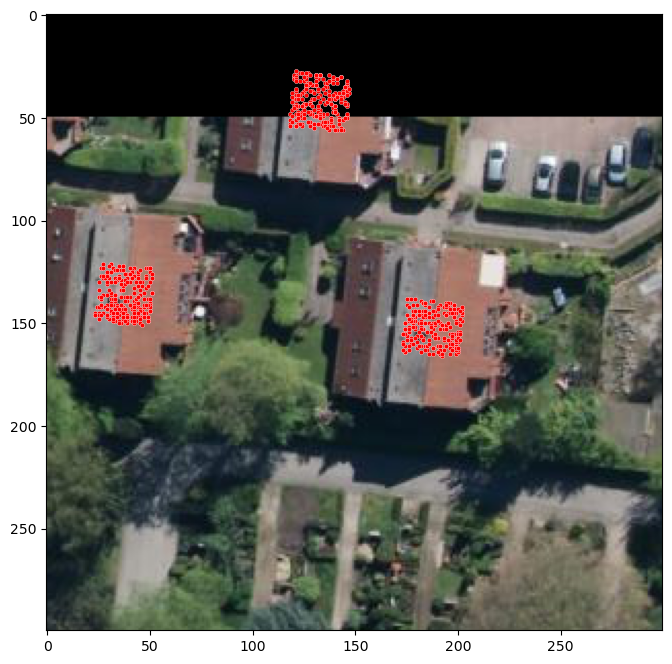

In [ ]:
example_img = data[2]

input_label, input_points = get_points_a_labels(targets[2], non_targets[2], num_to_remove=0.999, num_pos_remove=0.9)

input_label = np.array(input_label)
input_points = np.array(input_points)

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
        return_logits=True
    )

plt.figure(figsize=(12,12))
for j, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(1,3,j+1)
    mask_tensor = torch.from_numpy(masks[j])
    softmax_mask = torch.nn.functional.softmax(mask_tensor, dim=-1)
    #softmax_mask = torch.sigmoid(mask_tensor)
    plt.imshow(example_img, alpha=0.6)
    plt.imshow(softmax_mask,cmap='jet', alpha=0.8)
    plt.title(f"Mask {j+1}, Score: {score:.3f}", fontsize=18)
plt.show()

KeyboardInterrupt: 

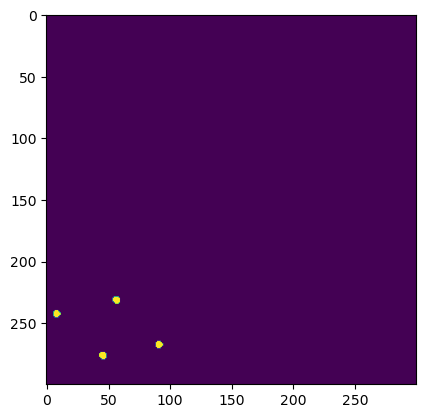

In [ ]:
plt.imshow(targets[3])

In [ ]:
example_img = data[1]
input_label, input_points = get_points_a_labels(targets[1], non_targets[1], num_to_remove=0.9999)

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

KeyboardInterrupt: 

In [ ]:
masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
    )
small_individual_masks.append(masks[0])
medium_individual_masks.append(masks[1])
large_individual_masks.append(masks[2])

plt.figure(figsize=(12,12))
for j, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(1,3,j+1)
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {j+1}, Score: {score:.3f}", fontsize=18)
plt.show()

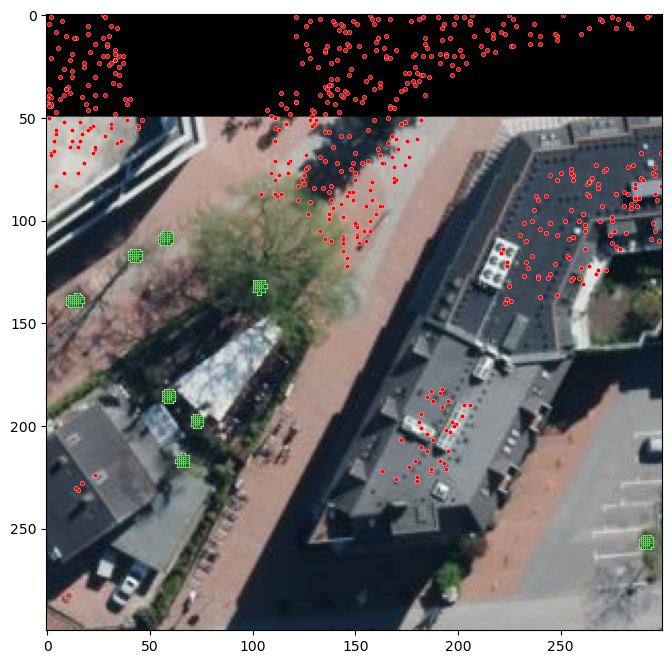

In [ ]:
example_img = data[1]
input_label, input_points = get_points_a_labels(targets[1], non_targets[1], num_to_remove=0.9999)

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

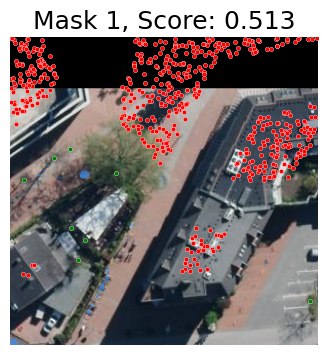

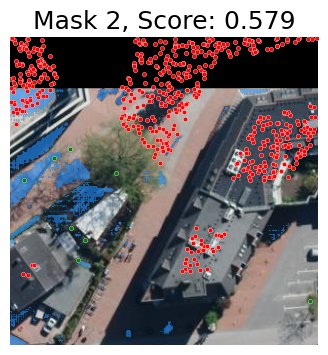

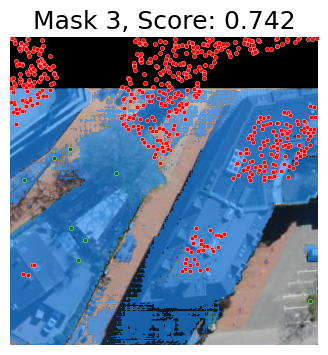

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() #the "score" is an estimation of the mask quality

In [ ]:
lmac-dopfkopå 


In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=inp_pointt,
    point_labels=inp_labell,
    multimask_output=True,
)

: 

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(inp_pointt, inp_labell, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() #the "score" is an estimation of the mask quality

: 

In [ ]:
from scipy.ndimage import label

def extract_bboxes(segmentation_mask):
    labeled_mask, num_labels = label(segmentation_mask)

    bounding_boxes = []
    for label_id in range(1, num_labels + 1):
        label_indices = np.where(labeled_mask == label_id)

        x_min = np.min(label_indices[1])
        y_min = np.min(label_indices[0])
        x_max = np.max(label_indices[1])
        y_max = np.max(label_indices[0])

        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return bounding_boxes

extract_bboxes(masks[0])

: 

In [ ]:
example_img, example_mask = data[0], mask

plt.figure(figsize=(10,10))
plt.imshow(example_img)
#show_mask(example_mask, plt.gca())
show_box(extract_bboxes(example_mask)[-1], plt.gca())
show_box(extract_bboxes(example_mask)[-2], plt.gca())
plt.axis('on')
plt.show()

: 

In [ ]:
#try:
#    from ultralytics import YOLO
#except:
#    !pip install ultralytics
#    from ultralytics import YOLO

#model = YOLO('yolov8n.pt')  # load a pretrained model, which is also recommended for further training

# Train the model, data required to be on the right format
# model.train(data='/custom.yaml', epochs=100, imgsz=256)

: 

In [ ]:
#small test
#prediction = model.predict(x_train[0])
#prediction[0].boxes.xyxy


: 

: 